### Welcome to DATA 602: Introduction to Data Analysis and Machine Learning Spring 2019 Term Project
#### My experiments with word2vec among other things...

We are going to use the following datasets:
* [IMDB Movie Review Dataset](https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz)

Below, we install and import required libraries

In [1]:
!pip install gensim tensorflow wordcloud
!pip install -q tensorflow-hub
!pip install xgboost
!pip install keras
!pip install nltk
!pip install string
!pip install tqdm

import gzip
import gensim
import os
import sys
import json
import shutil
import time
import re
import tarfile
import zipfile

import numpy as np
import pandas as pd
import collections
import math
import random
import datetime as dt

import matplotlib.pyplot as plt 
import seaborn as sns
%matplotlib inline
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

import string
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
nltk.download('punkt')
from nltk.tokenize import word_tokenize

from gensim.test.utils import get_tmpfile
from gensim.models import Word2Vec, FastText

from tqdm import tqdm
tqdm.pandas(desc="progress-bar")
from gensim.models import Doc2Vec
from gensim.models.doc2vec import LabeledSentence
import multiprocessing

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.pipeline import Pipeline


import tensorflow as tf
import tensorflow_hub as hub

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding,Dense,Flatten,GlobalMaxPooling1D,LSTM,Dropout, Activation,Bidirectional
from keras.layers.convolutional import Conv1D,MaxPooling1D 
from keras.optimizers import Adam

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, roc_curve, precision_recall_curve 
from sklearn import utils

"""
We will ignore FutureWarning and DeprecationWarning
"""
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)

"""
We will ignore warnings
"""
warnings.filterwarnings("ignore")

if not sys.warnoptions:
    warnings.simplefilter("ignore")
program_start_time=time.time()

  Using cached https://files.pythonhosted.org/packages/43/f1/d25dfdf1d28222124b920108b89f3f7acc2dad506014990c10fb34f7104b/gensim-3.7.2-cp36-cp36m-manylinux1_x86_64.whl
  Using cached https://files.pythonhosted.org/packages/77/63/a9fa76de8dffe7455304c4ed635be4aa9c0bacef6e0633d87d5f54530c5c/tensorflow-1.13.1-cp36-cp36m-manylinux1_x86_64.whl
  Using cached https://files.pythonhosted.org/packages/ae/af/849edf14d573eba9c8082db898ff0d090428d9485371cc4fe21a66717ad2/wordcloud-1.5.0-cp36-cp36m-manylinux1_x86_64.whl
  Using cached https://files.pythonhosted.org/packages/0a/9d/8bd5d0e516b196f59f1c4439b424b8d4fa62d492a4b531aae322d2d82a7b/grpcio-1.20.1-cp36-cp36m-manylinux1_x86_64.whl
  Using cached https://files.pythonhosted.org/packages/bb/48/13f49fc3fa0fdf916aa1419013bb8f2ad09674c275b4046d5ee669a46873/tensorflow_estimator-1.13.0-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/0f/39/bdd75b08a6fba41f098b6cb091b9e8c7a80e1b4d679a581a0ccd17b10373/tensorboard-1.13.1-py3-non

[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/jovyan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
W0507 14:41:33.977085 140072427317056 __init__.py:56] Some hub symbols are not available because TensorFlow version is less than 1.14
Using TensorFlow backend.


#### Perform some housekeeping tasks

In [2]:
data_source_url = 'https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz'
datasets = '/datasets/'
data_file_path = os.getcwd()+datasets+'aclImdb_v1.tar.gz'
data = 'data_'
MOVIE = 'movie'
data_folder = os.getcwd()+datasets+data+MOVIE
data_json_file = data+MOVIE+'.json'

def check_if_file_exists(file):
    '''
    Checks if 'file' exists
    '''
    try:
        fh = open(file, 'r')
        return True
    except FileNotFoundError:
        print('Please make sure file: ' + file + ' is present before continuing')
        return False

def check_if_dir_exists(directory):
    '''
    Checks if 'directory' exists
    '''
    return(os.path.isdir(directory))

def store_json(write_this_data):
    '''
    Store json if we are processing the first time
    '''
    open(data_json_file, 'w').write(json.dumps(write_this_data))

def return_data_json():
    '''
    Return data json from data json file
    '''
    with open(data_json_file, encoding='utf-8') as data_file:
        return json.loads(data_file.read())

**Download data source**

In [3]:
if not check_if_file_exists(data_file_path):
    print('Start of data download')
    wget.download(data_source_url, os.getcwd()+datasets)
    print('Download complete')
else:
    print('Data file already exists. Not downloading again!')

Data file already exists. Not downloading again!


In [4]:
if not check_if_dir_exists(data_folder):
    with tarfile.open(data_file_path) as tar:
        tar.extractall(path=data_folder)
else:
    print('Data foler exists. Won\'t copy again!')

Data foler exists. Won't copy again!


In [5]:
data = {}
all_reviews = []
if not check_if_file_exists(data_json_file):
    dirpath = data_folder+"/aclImdb/train/pos/"
    for root, dirs, files in os.walk(dirpath):
        for name in files:
            full = os.path.join(root, name)
            with open(full, 'r') as f:
                string = f.read()
                file_content = {"review": string,"rating": 1}
                all_reviews.append(file_content)
    dirpath = data_folder+"/aclImdb/train/neg/"
    for root, dirs, files in os.walk(dirpath):
        for name in files:
            full = os.path.join(root, name)
            with open(full, 'r') as f:
                string = f.read()
                file_content = {"review": string,"rating": 0}
                all_reviews.append(file_content)
    dirpath = data_folder+"/aclImdb/test/pos/"
    for root, dirs, files in os.walk(dirpath):
        for name in files:
            full = os.path.join(root, name)
            with open(full, 'r') as f:
                string = f.read()
                file_content = {"review": string,"rating": 1}
                all_reviews.append(file_content)
    dirpath = data_folder+"/aclImdb/test/neg/"
    for root, dirs, files in os.walk(dirpath):
        for name in files:
            full = os.path.join(root, name)
            with open(full, 'r') as f:
                string = f.read()
                file_content = {"review": string,"rating": 0}
                all_reviews.append(file_content)
    data[MOVIE] = all_reviews
    store_json(data)
pre_loaded_data = return_data_json()
len(pre_loaded_data[MOVIE])

50000

**Creating review dataframe and Data clean up**

In [6]:
movie_df = pd.DataFrame(pre_loaded_data[MOVIE])
print('Before Cleanup : Shape of the Data Frame : {}'.format(movie_df.shape))
print('Remove missing values.')
movie_df.dropna(inplace=True)
movie_df.reset_index(drop=True,inplace=True)
print('Drop columns with duplicate data.')
movie_df.drop_duplicates()
print('After Cleanup : Shape of the Data Frame : {}'.format(movie_df.shape))
print('Counting null data per column.')
movie_df.isnull().sum()

Before Cleanup : Shape of the Data Frame : (50000, 2)
Remove missing values.
Drop columns with duplicate data.
After Cleanup : Shape of the Data Frame : (50000, 2)
Counting null data per column.


rating    0
review    0
dtype: int64

* **The dataframe contains 50000 rows and 2 columns**

**Let us look at the data types of columns**

In [7]:
movie_df.dtypes

rating     int64
review    object
dtype: object

In [8]:
"""
Ratings
"""
movie_df.rating.unique()

array([1, 0])

**Let us explore the data a bit using head(), tail(), info(), describe()**

In [9]:
movie_df.head()

,rating,review
0,1,This has got to be one of my very favorite Twi...
1,1,"""8 SIMPLE RULES... FOR DATING MY TEENAGE DAUGH..."
2,1,"Famous was ""famous"" for their tension and rele..."
3,1,I've noticed that a lot of people who post on ...
4,1,Ya. That is what I think. Sure it was still a ...


In [10]:
movie_df.tail()

,rating,review
49995,0,This is a standard action flick as we have see...
49996,0,... what a porn movie would look like if you t...
49997,0,Kudos to Baxley's DP for making this look like...
49998,0,"Once a month, I invite a few friends over for ..."
49999,0,I happened to catch this movie on late night T...


In [11]:
movie_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
rating    50000 non-null int64
review    50000 non-null object
dtypes: int64(1), object(1)
memory usage: 781.3+ KB


In [12]:
movie_df.describe()

,rating
count,50000.000000
mean,0.500000
std,0.500005
min,0.000000
25%,0.000000
50%,0.500000
75%,1.000000
max,1.000000


In [13]:
movie_df.describe(include='object')

,review
count,50000
unique,49582
top,Loved today's show!!! It was a variety and not...
freq,5


In [14]:
movie_df.describe(include='all')

,rating,review
count,50000.000000,50000
unique,NaN,49582
top,NaN,Loved today's show!!! It was a variety and not...
freq,NaN,5
mean,0.500000,NaN
std,0.500005,NaN
min,0.000000,NaN
25%,0.000000,NaN
50%,0.500000,NaN
75%,1.000000,NaN


**Creating a new column called "review_length" which is the length of the review column.**

In [15]:
movie_df['review_length'] = movie_df['review'].apply(len)
movie_df.head()

,rating,review,review_length
0,1,This has got to be one of my very favorite Twi...,665
1,1,"""8 SIMPLE RULES... FOR DATING MY TEENAGE DAUGH...",712
2,1,"Famous was ""famous"" for their tension and rele...",908
3,1,I've noticed that a lot of people who post on ...,739
4,1,Ya. That is what I think. Sure it was still a ...,720


#### **Data Visualization and Exploratory Data Analysis**

**Using FacetGrid from the seaborn library to create a grid of two histograms of review_length based off of the ratings**

[FacetGrid reference](https://seaborn.pydata.org/generated/seaborn.FacetGrid.html)

In [16]:
sns.set_style('darkgrid')

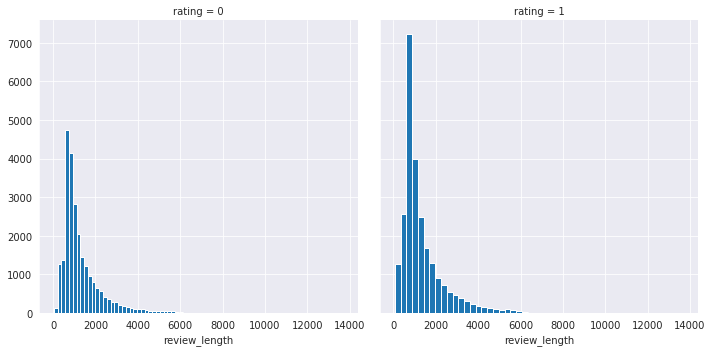

In [17]:
g = sns.FacetGrid(movie_df,col='rating',size=5)
g.map(plt.hist,'review_length',bins=50)
plt.show()

Let's try to explain why the x-axis goes all the way to 14000ish, this must mean that there is some really long message!

In [18]:
movie_df.review_length.describe()

count    50000.000000
mean      1309.431020
std        989.728014
min         32.000000
25%        699.000000
50%        970.000000
75%       1590.250000
max      13704.000000
Name: review_length, dtype: float64

* Max review_length 13704.000000 means review is 13704 character long

**Creating a boxplot of review_length for each rating category.**

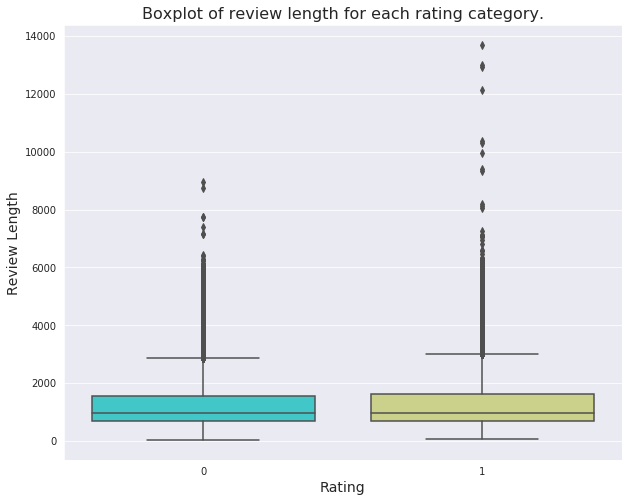

In [19]:
plt.figure(figsize=(10,8))
sns.boxplot(x='rating',y='review_length',data=movie_df,palette='rainbow')
plt.title("Boxplot of review length for each rating category.",fontsize=16)
plt.xlabel("Rating",fontsize=14)
plt.ylabel("Review Length",fontsize=14)
plt.show()

* Looking at the box and whisker plots for the review_length in words, we can see an exponential distribution. We can observe that the mass of the distribution can possibly be covered with 1400 to 1500 words.

**Creating a countplot of the number of occurrences for each type of rating.**

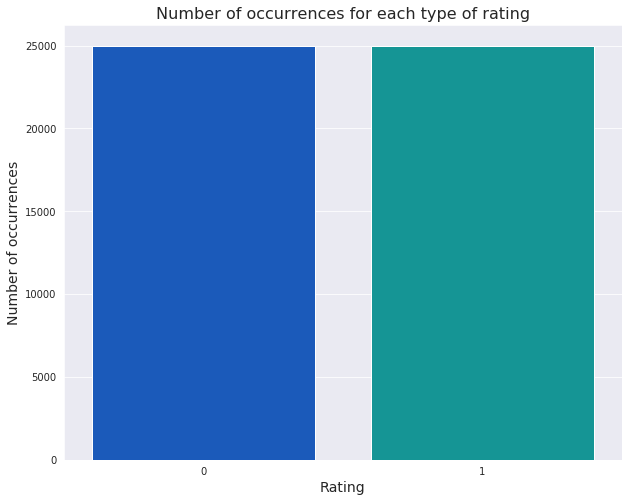

In [20]:
plt.figure(figsize=(10,8))
sns.countplot(x='rating',data=movie_df,palette='winter')
plt.title("Number of occurrences for each type of rating",fontsize=16)
plt.xlabel("Rating",fontsize=14)
plt.ylabel("Number of occurrences",fontsize=14)
plt.show()

**Pre-processing of review text**

[Regex reference](https://stackoverflow.com/questions/9662346/python-code-to-remove-html-tags-from-a-string/9662410)

In [21]:
def review_preprocess(review):
    """
    Takes in a string of review, then performs the following:
    1. Remove HTML tag from review
    2. Remove URLs from review
    3. Make entire review lowercase
    4. Split the review in words
    5. Remove all punctuation
    6. Remove empty strings from review
    7. Remove all stopwords
    8. Returns a list of the cleaned review after jioning them back to a sentence
    """
    en_stops = set(stopwords.words('english'))
    
    """
    Removing HTML tag from review
    """
    clean = re.compile('<.*?>')
    review_without_tag = re.sub(clean, '', review) 
    
    
    """
    Removing URLs
    """
    review_without_tag_and_url = re.sub(r"http\S+", "", review_without_tag)
    
    review_without_tag_and_url = re.sub(r"www\S+", "", review_without_tag)
    
    """
    Make entire string lowercase
    """
    review_lowercase = review_without_tag_and_url.lower()
    
    """
    Split string into words
    """
    list_of_words = word_tokenize(review_lowercase)
    
    
    """
    Remove punctuation
    Checking characters to see if they are in punctuation
    """

    list_of_words_without_punctuation=[''.join(this_char for this_char in this_string if (this_char in string.ascii_lowercase))for this_string in list_of_words]
     
    
    """
    Remove empty strings
    """
    list_of_words_without_punctuation = list(filter(None, list_of_words_without_punctuation))
    
    
    """
    Remove any stopwords
    """
  
    filtered_word_list = [w for w in list_of_words_without_punctuation if w not in en_stops] 
    
    """
    Returns a list of the cleaned review after jioning them back to a sentence
    """
    return ' '.join(filtered_word_list)

In [22]:
"""
Here is the original reviews:
"""
movie_df['review'].tail()

49995    This is a standard action flick as we have see...
49996    ... what a porn movie would look like if you t...
49997    Kudos to Baxley's DP for making this look like...
49998    Once a month, I invite a few friends over for ...
49999    I happened to catch this movie on late night T...
Name: review, dtype: object

**Applying pre-processing to reviews**

In [23]:
start_time=time.time()
movie_df['review']=movie_df['review'].apply(review_preprocess)
print('Elapsed time for review preprocessing : ',((time.time()-start_time)/60),' in minutes')

Elapsed time for review preprocessing :  2.637855299313863  in minutes


In [24]:
"""
Here is the reviews after preprocessing :
"""
movie_df['review'].tail()

49995    standard action flick seen many times much act...
49996    porn movie would look like took sex left bad d...
49997    kudos baxley dp making look like real movie fi...
49998    month invite friends retarded movie night look...
49999    happened catch movie late night tv saw opening...
Name: review, dtype: object

#### The term frequency distribution of words in the review is obtained using nltk.FreqDist(). This provides us a rough idea of the main topic in the review dataset.

[FreqDist reference](http://www.nltk.org/api/nltk.html?highlight=freqdist)

In [25]:
reviews = movie_df['review'].str.cat(sep=' ')

"""
function to split review into word
"""
tokens = word_tokenize(reviews)

vocabulary = set(tokens)
print('Number of vocabulary : {}'.format(len(vocabulary)))

frequency_distribution = nltk.FreqDist(tokens)
sorted(frequency_distribution,key=frequency_distribution.__getitem__, reverse=True)[0:50]

Number of vocabulary : 180605


['movie',
 'film',
 'nt',
 'one',
 'like',
 'good',
 'would',
 'even',
 'time',
 'really',
 'see',
 'story',
 'much',
 'well',
 'could',
 'get',
 'people',
 'great',
 'bad',
 'also',
 'first',
 'made',
 'make',
 'way',
 'movies',
 'think',
 'characters',
 'character',
 'watch',
 'films',
 'many',
 'seen',
 'two',
 'never',
 'love',
 'acting',
 'plot',
 'best',
 'show',
 'know',
 'little',
 'life',
 'ever',
 'better',
 'man',
 'say',
 'still',
 'scene',
 'end',
 'scenes']

#### Wordcloud visualization of frequent words

[Wordcloud reference](https://www.geeksforgeeks.org/generating-word-cloud-python/)

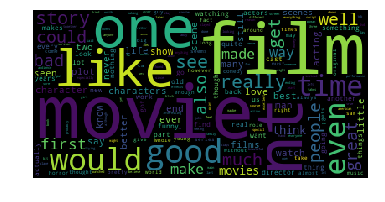

In [26]:
wordcloud = WordCloud().generate_from_frequencies(frequency_distribution)
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

#### Train, test split

In [27]:
def split_train_test(x, y):
    SEED = 2000
    x_train, x_validation_and_test, y_train, y_validation_and_test = train_test_split(x, y, test_size=.2, random_state=SEED)
    x_validation, x_test, y_validation, y_test = train_test_split(x_validation_and_test, y_validation_and_test, test_size=.5, random_state=SEED)
    return x_train, y_train, x_test, y_test, x_validation, y_validation, pd.concat([x_train,x_validation,x_test])

In [28]:
X = movie_df.review
y = movie_df.rating
x_train, y_train, x_test, y_test, x_validation, y_validation, all_reviews = split_train_test(X, y)

### We are done pre-processing! Now on to the data analysis and machine learning tasks...

* In the next code cell we reload data if needed or for first time load we simply read data into lists of tokenized items
* Then we train the Word2Vec model

<span style="display:block;text-align:center">![hobbits](hobbits.jpg)

### Concerning embeddings:
* Developed by [Tomas Mikolov in 2013 at Google](https://arxiv.org/pdf/1310.4546.pdf), **Word2Vec** is one of the most popular algorithms to train "word embeddings" using a shallow two layer neural networks having one input layer, one hidden layer and one output layer. There are two models for generating word embeddings, i.e. CBOW and Skip-gram.
* **Word Embedding** is a language modeling technique that uses vectors with several dimensions to represent words from large amounts of unstructured text data. Word embeddings can be generated using various methods like neural networks, co-occurrence matrix, probabilistic models, etc.
* **CBOW (Continuous Bag of Words) model** CBOW model predicts the current word given a context of words. The input layer contains context words and the output layer contains current predicted word. The hidden layer contains the number of dimensions in which we want to represent current word at output layer. The CBOW architecture is shown below ([image credit: Google](https://www.google.com/search?q=cbow&newwindow=1&source=lnms&tbm=isch&sa=X&ved=0ahUKEwibmL_l0YLiAhWoT98KHX8QAisQ_AUIDigB&biw=1855&bih=906))

<span style="display:block;text-align:center">![CBOW](CBOW_ORIGINAL.png)

* **Skip-gram model** flips CBOW's network architecture and aims to predict context given a word. Given current word, Skip gram predicts the surrounding context words. Input layer for it contains the current word and output layer provides the context words. The hidden layer consists of number of dimensions in which we want to represent current input word. The skip-gram architecture is shown below ([image credit: Google](https://www.google.com/search?q=skip+gram&newwindow=1&source=lnms&tbm=isch&sa=X&ved=0ahUKEwjSirSW0oLiAhUOd98KHbbgA5EQ_AUIDygC&biw=1855&bih=952))

<span style="display:block;text-align:center">![SG](skip.png)

* For our Word2Vec modeling we have used CBOW as it is faster and have better representation for more frequent words.

[Word2Vec reference](https://radimrehurek.com/gensim/models/word2vec.html)

**Reload previously processed model if exists**

In [29]:
list_of_tokenized_reviews = []
skip_modeling = False

filename_to_save_model = MOVIE + ".model"
if check_if_file_exists(filename_to_save_model):
    skip_modeling = True

In [30]:
if not skip_modeling:
    for one_sentence in all_reviews:
        list_of_tokenized_reviews.append(gensim.utils.simple_preprocess(one_sentence))
    model = Word2Vec(list_of_tokenized_reviews, size=150, window=10, min_count=2, workers=10)
    model.save(filename_to_save_model)
    model = Word2Vec.load(filename_to_save_model)
else:
    model = Word2Vec.load(filename_to_save_model)

W0507 14:44:51.753911 140072427317056 smart_open_lib.py:385] this function is deprecated, use smart_open.open instead


#### Let's look at some output

In [31]:
"""
look up top 10 words similar to the word 'terrible'.
"""
w1 = "terrible"
model.wv.most_similar(positive=w1)

[('horrible', 0.909416675567627),
 ('awful', 0.8847770690917969),
 ('horrid', 0.8349412679672241),
 ('horrendous', 0.8293353319168091),
 ('atrocious', 0.8127287030220032),
 ('lousy', 0.7956128120422363),
 ('dreadful', 0.7910779714584351),
 ('sucks', 0.7720378041267395),
 ('pathetic', 0.7427937984466553),
 ('laughable', 0.742027759552002)]

In [32]:
"""
look up top 10 words similar to 'excellent'
"""
w1 = ["excellent"]
model.wv.most_similar (positive=w1)

[('superb', 0.8720076680183411),
 ('outstanding', 0.8481285572052002),
 ('terrific', 0.8366817831993103),
 ('fantastic', 0.8252926468849182),
 ('fine', 0.7947401404380798),
 ('wonderful', 0.7863712906837463),
 ('exceptional', 0.7859656810760498),
 ('great', 0.7494642734527588),
 ('phenomenal', 0.7335102558135986),
 ('brilliant', 0.7279271483421326)]

In [33]:
"""
look up top 3 words similar to 'movie'
"""
w1 = ["movie"]
model.wv.most_similar (positive=w1,topn=3)

[('movies', 0.6096152067184448),
 ('moviei', 0.5753039717674255),
 ('film', 0.554874837398529)]

In [34]:
"""
look up top 5 words similar to 'worst'
"""
w1 = ["worst"]
model.wv.most_similar (positive=w1,topn=5)

[('stupidest', 0.7872093915939331),
 ('dumbest', 0.7310155630111694),
 ('lamest', 0.6975992918014526),
 ('cheesiest', 0.6749032139778137),
 ('scariest', 0.6707153916358948)]

In [35]:
"""
similarity between two different words
"""
model.wv.similarity(w1="great",w2="worse")

0.013156236

In [36]:
"""
similarity between two identical words
"""
model.wv.similarity(w1="outstanding",w2="outstanding")

1.0

In [37]:
"""
similarity between two related words
"""
model.wv.similarity(w1="excellent",w2="outstanding")

0.84812856

In [38]:
"""
Which one is the odd one out in this list?
"""
model.wv.doesnt_match(["best","great","good","disapointed"])

'disapointed'

In [39]:
"""
Which one is the odd one out in this list?
"""
model.wv.doesnt_match(["movie","film","show","book"])

'book'

* **Using dimensionality reduction algorithms like PCA and t-SNE to convert multi-dimensional word vectors to two dimensional plots**
* The goal is to plot our 150 dimensions vectors into 2 dimensional graphs, and check if we can spot interesting patterns.
* Using PCA and t-SNE implementation from scikit-learn for dimension reductions.
* In the visualizations we will look at query word (in **blue**), and most similar words (in **green**), and list of words passed in the function (in **red**).

In [40]:
def word_vectors_plot(model, input_word, word_list):
    """ 
    Seaborn plot results of query word and most similar words, alongwith other words in corpus
    """
    word_arrays = np.empty((0, 150), dtype='f')
    word_tags = [input_word]
    color_list  = ['blue']

    """
    Creating Vector of query word
    """
    word_arrays = np.append(word_arrays, model.wv.__getitem__([input_word]), axis=0)
    
    """
    Find similar words
    """
    similar_words = model.wv.most_similar([input_word],topn=8)
    
    """
    Insert word vector for similar words into array
    """
    for word_score in similar_words:
        word_vector = model.wv.__getitem__([word_score[0]])
        word_tags.append(word_score[0])
        color_list.append('green')
        word_arrays = np.append(word_arrays, word_vector, axis=0)
    
    """
    Insert word vectors for other words into array
    """
    for word in word_list:
        word_vector = model.wv.__getitem__([word])
        word_tags.append(word)
        color_list.append('red')
        word_arrays = np.append(word_arrays, word_vector, axis=0)
        
    """
    Dimensionality from 150 to 17 dimensions with PCA
    """
    reduce = PCA(n_components=17).fit_transform(word_arrays)
    
    
    """
    Finds t-SNE coordinates for 2 dimensions
    """
    np.set_printoptions(suppress=True)
    
    Y = TSNE(n_components=2, random_state=0, perplexity=15).fit_transform(reduce)
    
    
    """
    Sets everything up to plot
    """
    df = pd.DataFrame({'x': [x for x in Y[:, 0]],
                       'y': [y for y in Y[:, 1]],
                       'words': word_tags,
                       'color': color_list})
    
    fig, _ = plt.subplots()
    fig.set_size_inches(9, 9)
    
    
    """
    Original plot
    """
    p1 = sns.regplot(data=df,
                     x="x",
                     y="y",
                     fit_reg=False,
                     marker="o",
                     scatter_kws={'s': 40,
                                  'facecolors': df['color']
                                 }
                    )
    
    
    """
    Annotating word in plots
    """
    for line in range(0, df.shape[0]):
         p1.text(df["x"][line],
                 df['y'][line],
                 '  ' + df["words"][line].title(),
                 horizontalalignment='left',
                 verticalalignment='bottom', size='medium',
                 color=df['color'][line],
                 weight='normal'
                ).set_size(15)

    
    plt.xlim(Y[:, 0].min()-50, Y[:, 0].max()+50)
    plt.ylim(Y[:, 1].min()-50, Y[:, 1].max()+50)
            
    plt.title('t-SNE viz for input: {}'.format(input_word.title()),fontsize=16)

#### Eight Most Similar Words Vs. Eight Random Words

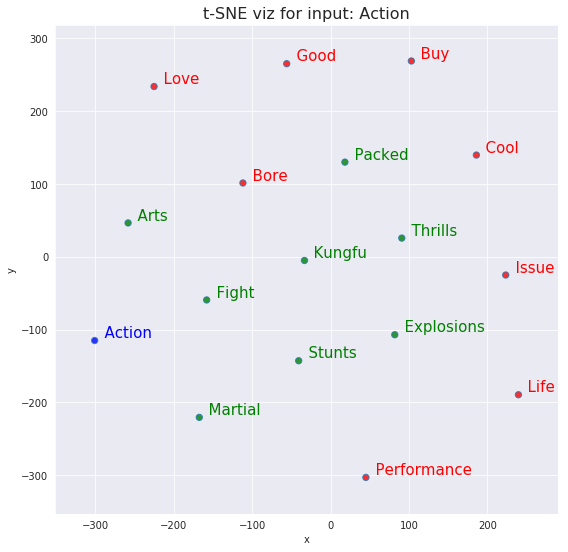

In [41]:
word_vectors_plot(model, 'action', ['good', 'performance', 'cool', 'life', 'issue', 'bore', 'buy', 'love'])

#### Eight Most Similar Words Vs. Ninth To Sixteenth Most Similar Words

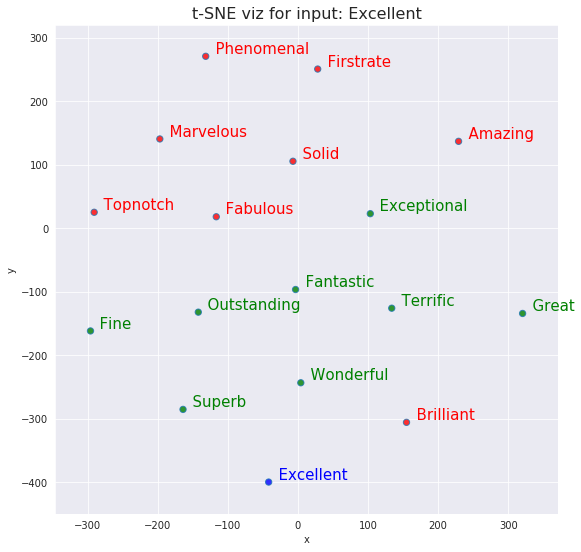

In [42]:
word_vectors_plot(model, "excellent", [t[0] for t in model.wv.most_similar(positive=["excellent"], 
                                                                             topn=16)][8:])

#### Eight Most Similar Words Vs. Ninth To Sixteenth Most Similar Words

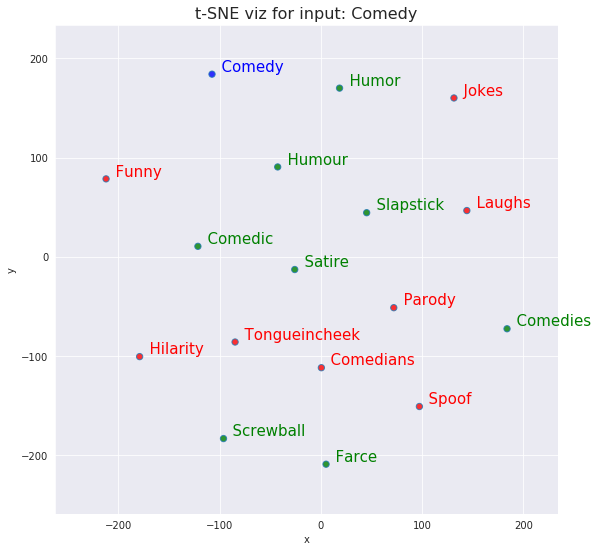

In [43]:
word_vectors_plot(model, "comedy", [t[0] for t in model.wv.most_similar(positive=["comedy"], 
                                                                             topn=16)][8:])

#### Eight Most Similar Words Vs. Ninth To Sixteenth Most Similar Words

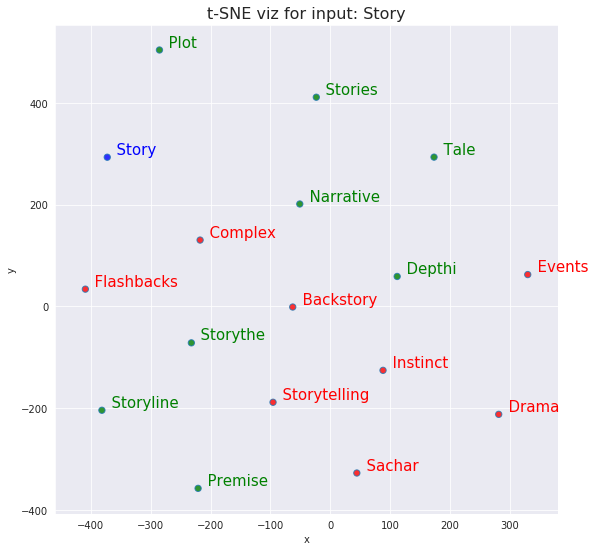

In [44]:
word_vectors_plot(model, "story", [t[0] for t in model.wv.most_similar(positive=["story"], 
                                                                             topn=16)][8:])

#### Wordcloud visualization of positive words in reviews

In [45]:
pos_lst=[t[0] for t in model.wv.most_similar(positive=["outstanding"],topn=20)]
pos_wrd=' '.join(pos_lst)
print(pos_wrd)

superb exceptional terrific phenomenal stellar excellent firstrate fabulous topnotch magnificent marvelous splendid superlative fine fantastic flawless masterful impeccable wonderful kudos


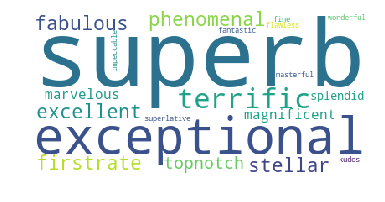

In [46]:
wordcloud = WordCloud(background_color='white',
                      max_words=200000,
                      max_font_size=400).generate(pos_wrd)
plt.figure()
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

#### Wordcloud visualization of negative words in reviews

In [47]:
neg_lst=[n[0] for n in model.wv.most_similar(positive=["awful"],topn=20)]
neg_wrd=' '.join(neg_lst)
print(neg_wrd)

terrible horrible atrocious horrid dreadful horrendous lousy sucks pathetic appalling abysmal laughable bad lame crappy pitiful stinks poor sucked unwatchable


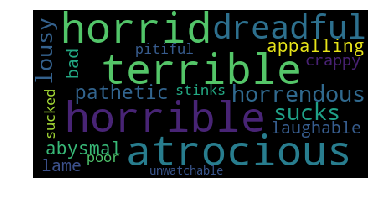

In [48]:
wordcloud = WordCloud(background_color='black',
                      max_words=100,
                      max_font_size=50).generate(neg_wrd)
plt.figure()
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

#### **Generating Feature vectors**

In [49]:
"""
Function to generate feature vectors
"""

def generate_feature_vectors(doc, model):
    vec = np.zeros(150).reshape((1, 150))  
    count = 0
    for word in gensim.utils.simple_preprocess(doc):
        if model.__contains__(word.strip()):
            count = count + 1
            vec += model[word.strip()]
    vec = vec / count
    return vec

def generate_features(model, data):
    features = np.concatenate([generate_feature_vectors(s, model) for s in data])
    return features

"""
Generating train, test and validation vectors
"""

training_vectors = generate_features(model, x_train)
test_vectors = generate_features(model, x_test)
validation_vectors = generate_features(model, x_validation)

####  Word2Vec Word Embedding Based Sentiment Analysis using LogisticRegression

In [50]:
lr = LogisticRegression()
lr.fit(training_vectors, y_train)
print("***** Word2Vec Word Embedding Based Sentiment Analysis using LogisticRegression *******\n")
print("LogisticRegression Performance : \n")
print('Train-Set Score : {:.4f}'.format(lr.score(training_vectors, y_train)))
print('Train-Set Accuracy : {:.4f}'.format(accuracy_score(y_train,lr.predict(training_vectors))))

print("\nEvaluation on Validation-Set : ")
pred_val = lr.predict(validation_vectors)
print("Classification report:\n {}".format(classification_report(y_validation, pred_val)))
print("Confusion matrix:\n {}".format(confusion_matrix(y_validation, pred_val)))
print('Validation-Set Score : {:.4f}'.format(lr.score(validation_vectors, y_validation)))
print('Validation-Set Accuracy:{:.4f}'.format(accuracy_score(y_validation, pred_val)))

print("\nEvaluation on Test-Set : ")
pred = lr.predict(test_vectors)
print("Classification report:\n {}".format(classification_report(y_test, pred)))
print("Confusion matrix:\n {}".format(confusion_matrix(y_test, pred)))
print('Test-Set Score : {:.4f}'.format(lr.score(test_vectors, y_test)))
print('Test-Set Accuracy:{:.4f}'.format(accuracy_score(y_test, pred)))

***** Word2Vec Word Embedding Based Sentiment Analysis using LogisticRegression *******

LogisticRegression Performance : 

Train-Set Score : 0.8753
Train-Set Accuracy : 0.8753

Evaluation on Validation-Set : 
Classification report:
               precision    recall  f1-score   support

           0       0.88      0.86      0.87      2513
           1       0.86      0.88      0.87      2487

   micro avg       0.87      0.87      0.87      5000
   macro avg       0.87      0.87      0.87      5000
weighted avg       0.87      0.87      0.87      5000

Confusion matrix:
 [[2152  361]
 [ 293 2194]]
Validation-Set Score : 0.8692
Validation-Set Accuracy:0.8692

Evaluation on Test-Set : 
Classification report:
               precision    recall  f1-score   support

           0       0.88      0.86      0.87      2529
           1       0.86      0.88      0.87      2471

   micro avg       0.87      0.87      0.87      5000
   macro avg       0.87      0.87      0.87      5000
weighted 

####  Word2Vec Word Embedding Based Sentiment Analysis using SVC

In [51]:
svm = SVC(kernel='linear')
svm.fit(training_vectors, y_train)
print("***** Word2Vec Word Embedding Based Sentiment Analysis using SVC *******\n")
print("SVC with linear kernel Performance : \n")
print('Train-Set Score : {:.4f}'.format(svm.score(training_vectors, y_train)))
print('Train-Set Accuracy : {:.4f}'.format(accuracy_score(y_train,svm.predict(training_vectors))))

print("\nEvaluation on Validation-Set : ")
pred_val = svm.predict(validation_vectors)
print("Classification report:\n {}".format(classification_report(y_validation, pred_val)))
print("Confusion matrix:\n {}".format(confusion_matrix(y_validation, pred_val)))
print('Validation-Set Score : {:.4f}'.format(svm.score(validation_vectors, y_validation)))
print('Validation-Set Accuracy:{:.4f}'.format(accuracy_score(y_validation, pred_val)))

print("\nEvaluation on Test-Set : ")
pred = svm.predict(test_vectors)
print("Classification report:\n {}".format(classification_report(y_test, pred)))
print("Confusion matrix:\n {}".format(confusion_matrix(y_test, pred)))
print('Test-Set Score : {:.4f}'.format(svm.score(test_vectors, y_test)))
print("Test-Set Accuracy: {:.4f}".format(accuracy_score(y_test, pred)))

***** Word2Vec Word Embedding Based Sentiment Analysis using SVC *******

SVC with linear kernel Performance : 

Train-Set Score : 0.8755
Train-Set Accuracy : 0.8755

Evaluation on Validation-Set : 
Classification report:
               precision    recall  f1-score   support

           0       0.88      0.86      0.87      2513
           1       0.86      0.89      0.87      2487

   micro avg       0.87      0.87      0.87      5000
   macro avg       0.87      0.87      0.87      5000
weighted avg       0.87      0.87      0.87      5000

Confusion matrix:
 [[2151  362]
 [ 281 2206]]
Validation-Set Score : 0.8714
Validation-Set Accuracy:0.8714

Evaluation on Test-Set : 
Classification report:
               precision    recall  f1-score   support

           0       0.88      0.86      0.87      2529
           1       0.86      0.88      0.87      2471

   micro avg       0.87      0.87      0.87      5000
   macro avg       0.87      0.87      0.87      5000
weighted avg       0

#### Word2Vec Word Embedding Based Sentiment Analysis using XGBClassifier

In [52]:
xgb = XGBClassifier()
xgb.fit(training_vectors, y_train)
print("***** Word2Vec Word Embedding Based Sentiment Analysis using XGBClassifier *******\n")
print("XGBClassifier Performance : \n")
print('Train-Set Score : {:.4f}'.format(xgb.score(training_vectors, y_train)))
print('Train-Set Accuracy : {:.4f}'.format(accuracy_score(y_train,xgb.predict(training_vectors))))

print("\nEvaluation on Validation-Set : ")
pred_val = xgb.predict(validation_vectors)
print("Classification report:\n {}".format(classification_report(y_validation, pred_val)))
print("Confusion matrix:\n {}".format(confusion_matrix(y_validation, pred_val)))
print('Validation-Set Score : {:.4f}'.format(xgb.score(validation_vectors, y_validation)))
print('Validation-Set Accuracy:{:.4f}'.format(accuracy_score(y_validation, pred_val)))


print("\nEvaluation on Test-Set : ")
pred = xgb.predict(test_vectors)
print("Classification report:\n {}".format(classification_report(y_test, pred)))
print("Confusion matrix:\n {}".format(confusion_matrix(y_test, pred)))
print("Test-Set Score : {:.4f}".format(xgb.score(test_vectors, y_test)))
print("Test-Set Accuracy: {:.4f}".format(accuracy_score(y_test, pred)))

***** Word2Vec Word Embedding Based Sentiment Analysis using XGBClassifier *******

XGBClassifier Performance : 

Train-Set Score : 0.8695
Train-Set Accuracy : 0.8695

Evaluation on Validation-Set : 
Classification report:
               precision    recall  f1-score   support

           0       0.87      0.83      0.85      2513
           1       0.84      0.87      0.86      2487

   micro avg       0.85      0.85      0.85      5000
   macro avg       0.85      0.85      0.85      5000
weighted avg       0.85      0.85      0.85      5000

Confusion matrix:
 [[2096  417]
 [ 313 2174]]
Validation-Set Score : 0.8540
Validation-Set Accuracy:0.8540

Evaluation on Test-Set : 
Classification report:
               precision    recall  f1-score   support

           0       0.86      0.84      0.85      2529
           1       0.84      0.86      0.85      2471

   micro avg       0.85      0.85      0.85      5000
   macro avg       0.85      0.85      0.85      5000
weighted avg       

#### Sentiment Analysis using Keras Convolutional Neural Networks(CNN) 

[Keras reference](https://blog.keras.io/using-pre-trained-word-embeddings-in-a-keras-model.html)

In [53]:
"""
Create the tokenizer
"""
number_of_words=len(vocabulary)
tokenizer = Tokenizer(num_words=number_of_words)

"""
Fit the tokenizer
"""
tokenizer.fit_on_texts(x_train)

"""
Sequence encode
"""
X_token_train = tokenizer.texts_to_sequences(x_train)
X_token_test = tokenizer.texts_to_sequences(x_test)
X_token_validation = tokenizer.texts_to_sequences(x_validation)

"""
Adding 1 because of reserved 0 index
"""
vocabulary_size = len(tokenizer.word_index) + 1  

print("x_train[2] : ",x_train[2])
print("\n X_token_train[2] : ",X_token_train[2])
print("\n vocab_size : ",vocabulary_size)

x_train[2] :  famous famous tension release style cartoon semimain character terrible peril rescued hero last second particular casper one remember death actually takes hand even death still happy endingthe constant famous studios cartoons virtue always triumphs popeye always gets spinach time baby huey always outfoxes fox little audery always learns lesson fs cartoons really dark depressingyou give credit much love looney tunes tom jerry nt think anyone putting better cartoon product time paramount color animation music great winston sharples editing voices consistent glowing example best art form offer

 X_token_train[2] :  [647, 4052, 647, 3, 68, 177, 10, 373, 252, 10055, 9061, 1046, 3, 2853, 340, 253, 202, 38, 1851, 951, 4999, 2666, 2037, 9756, 6701, 17593, 180, 11092, 17049, 3613, 372, 356, 21986, 350, 6591, 1093, 104, 1051, 12429, 483, 2111, 605, 384, 3116, 3147, 781, 4628, 3614, 126, 699, 2, 809, 5037, 5215, 2612, 70, 141, 67006, 11092, 10384, 1025, 726, 86, 4407, 801, 1004, 871

In [54]:
"""
Checking the index of each word by looking at the word_index dictionary of the Tokenizer object
"""
for word in ['famous','cartoon','studios', 'love', 'baby']:
    print('{} : {}'.format(word, tokenizer.word_index[word]))

famous : 662
cartoon : 877
studios : 2378
love : 36
baby : 806


In [55]:
"""
Pad sequences
"""
max_length = 1500

X_token_train = pad_sequences(X_token_train, padding='post', maxlen=max_length)
X_token_test = pad_sequences(X_token_test, padding='post', maxlen=max_length)
X_token_validation = pad_sequences(X_token_validation, padding='post', maxlen=max_length)

In [56]:
%%time
"""
Create model
"""
embedding_dimension = 100

keras_cnn_model = Sequential()
keras_cnn_model.add(Embedding(input_dim=vocabulary_size, 
                              output_dim=embedding_dimension, 
                              input_length=max_length))
keras_cnn_model.add(Conv1D(128, 5, activation='relu'))
keras_cnn_model.add(GlobalMaxPooling1D())
keras_cnn_model.add(Dense(10, activation='relu'))
keras_cnn_model.add(Dense(1, activation='sigmoid'))

"""
Compile network
"""
keras_cnn_model.compile(optimizer='adam',
                        loss='binary_crossentropy',
                        metrics=['accuracy'])
keras_cnn_model.summary()

Instructions for updating:
Colocations handled automatically by placer.


W0507 14:54:43.152259 140072427317056 deprecation.py:323] From /opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/op_def_library.py:263: colocate_with (from tensorflow.python.framework.ops) is deprecated and will be removed in a future version.
Instructions for updating:
Colocations handled automatically by placer.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 1500, 100)         15813200  
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 1496, 128)         64128     
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                1290      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 11        
Total params: 15,878,629
Trainable params: 15,878,629
Non-trainable params: 0
_________________________________________________________________
CPU times: user 128 ms, sys: 0 ns, total: 128 ms
Wall time: 123 ms


In [57]:
%%time
"""
Fit network
"""
keras_cnn_model.fit(X_token_train, y_train,
                    epochs=5,
                    verbose=False,
                    validation_data=(X_token_validation, y_validation),
                    batch_size=10)

"""
Evaluate
"""
print("\n **** Sentiment Analysis Using Keras Convolutional Neural Networks(CNN) ****\n")
loss, accuracy = keras_cnn_model.evaluate(X_token_train, y_train, verbose=False)
print("Train-Set Accuracy: {:.4f}".format(accuracy))


print("\nEvaluation on Validation-Set : ")
pred_val=keras_cnn_model.predict_classes(X_token_validation)
print("Classification report:\n {}".format(classification_report(y_validation, pred_val)))
print("Confusion matrix:\n {}".format(confusion_matrix(y_validation, pred_val)))
loss, accuracy = keras_cnn_model.evaluate(X_token_validation, y_validation, verbose=False)
print("Validation-Set Accuracy: {:.4f}".format(accuracy))

print("\nEvaluation on Test-Set : ")
pred=keras_cnn_model.predict_classes(X_token_test)
print("Classification report:\n {}".format(classification_report(y_test, pred)))
print("Confusion matrix:\n {}".format(confusion_matrix(y_test, pred)))
loss, accuracy = keras_cnn_model.evaluate(X_token_test, y_test, verbose=False)
print("Test-Set Accuracy:  {:.4f}".format(accuracy))

Instructions for updating:
Use tf.cast instead.


W0507 14:54:43.302245 140072427317056 deprecation.py:323] From /opt/conda/lib/python3.6/site-packages/tensorflow/python/ops/math_ops.py:3066: to_int32 (from tensorflow.python.ops.math_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.cast instead.


Instructions for updating:
Deprecated in favor of operator or tf.math.divide.


W0507 14:54:43.437217 140072427317056 deprecation.py:323] From /opt/conda/lib/python3.6/site-packages/tensorflow/python/ops/math_grad.py:102: div (from tensorflow.python.ops.math_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.



 **** Sentiment Analysis Using Keras Convolutional Neural Networks(CNN) ****

Train-Set Accuracy: 0.9994

Evaluation on Validation-Set : 
Classification report:
               precision    recall  f1-score   support

           0       0.86      0.90      0.88      2513
           1       0.89      0.86      0.87      2487

   micro avg       0.88      0.88      0.88      5000
   macro avg       0.88      0.88      0.88      5000
weighted avg       0.88      0.88      0.88      5000

Confusion matrix:
 [[2252  261]
 [ 354 2133]]
Validation-Set Accuracy: 0.8770

Evaluation on Test-Set : 
Classification report:
               precision    recall  f1-score   support

           0       0.86      0.91      0.88      2529
           1       0.90      0.85      0.87      2471

   micro avg       0.88      0.88      0.88      5000
   macro avg       0.88      0.88      0.88      5000
weighted avg       0.88      0.88      0.88      5000

Confusion matrix:
 [[2302  227]
 [ 379 2092]]
Test-Set

#### Sentiment Analysis Using Pre-trained Word2Vec Word Embedding To Keras CNN

In [58]:
"""
Vocabulary size
"""
num_of_words = list(model.wv.vocab)
print('Vocabulary size : %d' % len(num_of_words))

Vocabulary size : 74272


In [59]:
%%time
"""
Save model in ASCII
"""
file_name = 'movie_embedding_word2vec.txt'
model.wv.save_word2vec_format(file_name, binary=False)

W0507 16:15:14.071372 140072427317056 smart_open_lib.py:385] this function is deprecated, use smart_open.open instead


CPU times: user 15.1 s, sys: 288 ms, total: 15.4 s
Wall time: 15.6 s


In [60]:
"""
Load word embedding
"""
def load_word_embedding(file_name):
    word_embedding = dict()
    file = open(file_name,'r')
    lines = file.readlines()[1:]
    file.close()
    
    """
    Mapping words to vectors
    """
    for line in lines:
        line_parts = line.split()
        word_embedding[line_parts[0]] = np.asarray(line_parts[1:], dtype='float32')
        
    return word_embedding

In [61]:
"""
Create a weight matrix for the Embedding layer
"""
def get_embedding_weight_matrix(wrd_embedding, vocabulary):
    
    vocabulary_size = len(vocabulary) + 1
    """
    Define weight matrix dimensions with all 0
    """
    embedding_weight_matrix = np.zeros((vocabulary_size, 150))
    """
    Step vocab, store vectors using the Tokenizer's integer mapping
    """
    for wrd, i in vocabulary.items():
        vector = wrd_embedding.get(wrd)
        if vector is not None:
            embedding_weight_matrix[i] = vector
    return embedding_weight_matrix

In [62]:
"""
Load embedding from file
"""
raw_w2v_embedding = load_word_embedding('movie_embedding_word2vec.txt')

print('Completed creation of raw word2vec word embedding')

"""
Get weight vectors in the right order
"""
embedding_weight_vectors = get_embedding_weight_matrix(raw_w2v_embedding, tokenizer.word_index)

print('Completed creation of embedding weight vectors')

Completed creation of raw word2vec word embedding
Completed creation of embedding weight vectors


In [63]:
"""
Create the embedding layer
"""
embedding_layer = Embedding(vocabulary_size, 
                            150, 
                            weights=[embedding_weight_vectors], 
                            input_length=max_length, 
                            trainable=False)

print('Completed creation of embedding layer')

Completed creation of embedding layer


In [64]:
"""
Create model
"""
keras_cnn_w2v_model = Sequential()
keras_cnn_w2v_model.add(embedding_layer)
keras_cnn_w2v_model.add(Conv1D(filters=128, kernel_size=5, activation='relu'))
keras_cnn_w2v_model.add(MaxPooling1D(pool_size=2))
keras_cnn_w2v_model.add(Flatten())
keras_cnn_w2v_model.add(Dense(1, activation='sigmoid'))
keras_cnn_w2v_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 1500, 150)         23719800  
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 1496, 128)         96128     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 748, 128)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 95744)             0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 95745     
Total params: 23,911,673
Trainable params: 191,873
Non-trainable params: 23,719,800
_________________________________________________________________


In [65]:
"""
Compile network
"""
keras_cnn_w2v_model.compile(loss='binary_crossentropy', 
                            optimizer='adam', 
                            metrics=['accuracy'])

"""
Fit network
"""
keras_cnn_w2v_model.fit(X_token_train, y_train,
                        epochs=5,
                        verbose=False,
                        validation_data=(X_token_validation, y_validation),
                        batch_size=10)

"""
Evaluate
"""
print("\n **** Sentiment Analysis Using Pre-trained Word2Vec Word Embedding To Keras CNN ****\n")
loss, accuracy = keras_cnn_w2v_model.evaluate(X_token_train, y_train, verbose=False)
print("Train-Set Accuracy: {:.4f}".format(accuracy))


print("\nEvaluation on Validation-Set : ")
pred_val=keras_cnn_w2v_model.predict_classes(X_token_validation)
print("Classification report:\n {}".format(classification_report(y_validation, pred_val)))
print("Confusion matrix:\n {}".format(confusion_matrix(y_validation, pred_val)))
loss, accuracy = keras_cnn_w2v_model.evaluate(X_token_validation, y_validation, verbose=False)
print("Validation-Set Accuracy: {:.4f}".format(accuracy))

print("\nEvaluation on Test-Set : ")
pred=keras_cnn_w2v_model.predict_classes(X_token_test)
print("Classification report:\n {}".format(classification_report(y_test, pred)))
print("Confusion matrix:\n {}".format(confusion_matrix(y_test, pred)))
loss, accuracy = keras_cnn_w2v_model.evaluate(X_token_test, y_test, verbose=False)
print("Test-Set Accuracy:  {:.4f}".format(accuracy))


 **** Sentiment Analysis Using Pre-trained Word2Vec Word Embedding To Keras CNN ****

Train-Set Accuracy: 0.9593

Evaluation on Validation-Set : 
Classification report:
               precision    recall  f1-score   support

           0       0.84      0.85      0.85      2513
           1       0.85      0.84      0.84      2487

   micro avg       0.84      0.84      0.84      5000
   macro avg       0.84      0.84      0.84      5000
weighted avg       0.84      0.84      0.84      5000

Confusion matrix:
 [[2137  376]
 [ 402 2085]]
Validation-Set Accuracy: 0.8444

Evaluation on Test-Set : 
Classification report:
               precision    recall  f1-score   support

           0       0.83      0.83      0.83      2529
           1       0.83      0.82      0.82      2471

   micro avg       0.83      0.83      0.83      5000
   macro avg       0.83      0.83      0.83      5000
weighted avg       0.83      0.83      0.83      5000

Confusion matrix:
 [[2110  419]
 [ 447 2024]]


#### Sentiment Analysis  Using Pre-trained Word2Vec Word Embedding To Keras CNN And Bidirectional LSTM

In [66]:
%%time
"""
Create model
"""
keras_cnn_bidir_lstm_w2v_model = Sequential()
keras_cnn_bidir_lstm_w2v_model.add(Embedding(vocabulary_size, 
                                             150, 
                                             weights=[embedding_weight_vectors],
                                             input_length=max_length,  
                                             trainable=False))
keras_cnn_bidir_lstm_w2v_model.add(Conv1D(128, 5, activation='relu'))
keras_cnn_bidir_lstm_w2v_model.add(MaxPooling1D(pool_size=2))
keras_cnn_bidir_lstm_w2v_model.add(Bidirectional(LSTM(64)))
keras_cnn_bidir_lstm_w2v_model.add(Dropout(0.5))
keras_cnn_bidir_lstm_w2v_model.add(Dense(1, activation='sigmoid'))

"""
Compile network
"""
keras_cnn_bidir_lstm_w2v_model.compile(loss='binary_crossentropy', 
                                       optimizer='adam', 
                                       metrics=['accuracy'])
keras_cnn_bidir_lstm_w2v_model.summary()

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


W0507 16:42:33.180719 140072427317056 deprecation.py:506] From /opt/conda/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:3445: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 1500, 150)         23719800  
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 1496, 128)         96128     
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 748, 128)          0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 128)               98816     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 129       
Total params: 23,914,873
Trainable params: 195,073
Non-trainable params: 23,719,800
__________________________________________________________

In [67]:
%%time
"""
Fit train data
"""
keras_cnn_bidir_lstm_w2v_model.fit(X_token_train, y_train,
                                   epochs=5,
                                   verbose=False,
                                   validation_data=(X_token_validation, y_validation),
                                   batch_size=10)

CPU times: user 15h 18min 43s, sys: 1h 22min 27s, total: 16h 41min 10s
Wall time: 2h 23min 51s


In [68]:
"""
Evaluate
"""
print("**** Sentiment Analysis  Using Pre-trained Word2Vec Word Embedding To Keras CNN And Bidirectional LSTM ****\n")
loss, accuracy = keras_cnn_bidir_lstm_w2v_model.evaluate(X_token_train, y_train, verbose=False)
print("Train-Set Accuracy: {:.4f}".format(accuracy))

print("\nEvaluation on Validation-Set : ")
pred_val=keras_cnn_bidir_lstm_w2v_model.predict_classes(X_token_validation)
print("Classification report:\n {}".format(classification_report(y_validation, pred_val)))
print("Confusion matrix:\n {}".format(confusion_matrix(y_validation, pred_val)))
loss, accuracy = keras_cnn_bidir_lstm_w2v_model.evaluate(X_token_validation, y_validation, verbose=False)
print("Validation-Set Accuracy: {:.4f}".format(accuracy))

print("\nEvaluation on Test-Set : ")
pred=keras_cnn_bidir_lstm_w2v_model.predict_classes(X_token_test)
print("Classification report:\n {}".format(classification_report(y_test, pred)))
print("Confusion matrix:\n {}".format(confusion_matrix(y_test, pred)))
loss, accuracy = keras_cnn_bidir_lstm_w2v_model.evaluate(X_token_test, y_test, verbose=False)
print("Test-Set Accuracy:  {:.4f}".format(accuracy))

**** Sentiment Analysis  Using Pre-trained Word2Vec Word Embedding To Keras CNN And Bidirectional LSTM ****

Train-Set Accuracy: 0.9356

Evaluation on Validation-Set : 
Classification report:
               precision    recall  f1-score   support

           0       0.90      0.87      0.88      2513
           1       0.87      0.90      0.89      2487

   micro avg       0.89      0.89      0.89      5000
   macro avg       0.89      0.89      0.89      5000
weighted avg       0.89      0.89      0.89      5000

Confusion matrix:
 [[2184  329]
 [ 244 2243]]
Validation-Set Accuracy: 0.8854

Evaluation on Test-Set : 
Classification report:
               precision    recall  f1-score   support

           0       0.91      0.87      0.89      2529
           1       0.87      0.91      0.89      2471

   micro avg       0.89      0.89      0.89      5000
   macro avg       0.89      0.89      0.89      5000
weighted avg       0.89      0.89      0.89      5000

Confusion matrix:
 [[220

#### Sentiment Analysis Using Pre-trained Word2Vec Word Embedding To Keras Bidirectional LSTM

In [69]:
"""
Create model
"""

keras_bidir_lstm_w2v_model = Sequential()
keras_bidir_lstm_w2v_model.add(Embedding(vocabulary_size, 
                                         150, 
                                         weights=[embedding_weight_vectors],
                                         input_length=max_length,  
                                         trainable=False))
keras_bidir_lstm_w2v_model.add(Bidirectional(LSTM(64)))
keras_bidir_lstm_w2v_model.add(Dropout(0.5))
keras_bidir_lstm_w2v_model.add(Dense(1, activation='sigmoid'))


"""
Compile network
"""
keras_bidir_lstm_w2v_model.compile(loss='binary_crossentropy', 
                                   optimizer='adam', 
                                   metrics=['accuracy'])
keras_bidir_lstm_w2v_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 1500, 150)         23719800  
_________________________________________________________________
bidirectional_2 (Bidirection (None, 128)               110080    
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 129       
Total params: 23,830,009
Trainable params: 110,209
Non-trainable params: 23,719,800
_________________________________________________________________


In [70]:
%%time
"""
Fit train data
"""
keras_bidir_lstm_w2v_model.fit(X_token_train, y_train,
                               epochs=5,
                               verbose=False,
                               validation_data=(X_token_validation, y_validation),
                               batch_size=10)

CPU times: user 23h 22min 14s, sys: 2h 34min 46s, total: 1d 1h 57min
Wall time: 3h 43min 52s


In [71]:
"""
Evaluate
"""
print("**** Sentiment Analysis Using Pre-trained Word2Vec Word Embedding To Keras Bidirectional LSTM ****\n")
loss, accuracy = keras_bidir_lstm_w2v_model.evaluate(X_token_train, y_train, verbose=False)
print("Train-Set Accuracy: {:.4f}".format(accuracy))

print("\nEvaluation on Validation-Set : ")
pred_val=keras_bidir_lstm_w2v_model.predict_classes(X_token_validation)
print("Classification report:\n {}".format(classification_report(y_validation, pred_val)))
print("Confusion matrix:\n {}".format(confusion_matrix(y_validation, pred_val)))
loss, accuracy = keras_bidir_lstm_w2v_model.evaluate(X_token_validation, y_validation, verbose=False)
print("Validation-Set Accuracy: {:.4f}".format(accuracy))

print("\nEvaluation on Test-Set : ")
pred=keras_bidir_lstm_w2v_model.predict_classes(X_token_test)
print("Classification report:\n {}".format(classification_report(y_test, pred)))
print("Confusion matrix:\n {}".format(confusion_matrix(y_test, pred)))

loss, accuracy = keras_bidir_lstm_w2v_model.evaluate(X_token_test, y_test, verbose=False)
print("Test-Set Accuracy:  {:.4f}".format(accuracy))

**** Sentiment Analysis Using Pre-trained Word2Vec Word Embedding To Keras Bidirectional LSTM ****

Train-Set Accuracy: 0.9011

Evaluation on Validation-Set : 
Classification report:
               precision    recall  f1-score   support

           0       0.90      0.86      0.88      2513
           1       0.86      0.90      0.88      2487

   micro avg       0.88      0.88      0.88      5000
   macro avg       0.88      0.88      0.88      5000
weighted avg       0.88      0.88      0.88      5000

Confusion matrix:
 [[2152  361]
 [ 239 2248]]
Validation-Set Accuracy: 0.8800

Evaluation on Test-Set : 
Classification report:
               precision    recall  f1-score   support

           0       0.90      0.86      0.88      2529
           1       0.86      0.90      0.88      2471

   micro avg       0.88      0.88      0.88      5000
   macro avg       0.88      0.88      0.88      5000
weighted avg       0.88      0.88      0.88      5000

Confusion matrix:
 [[2176  353]
 

## About Doc2Vec

* **Doc2Vec** is a generalization of the Word2Vec algorithm and applies at the document level. According to [Mikolov et al. (2014)](https://arxiv.org/pdf/1405.4053.pdf), paragraphs in a document are mapped to a vector representation called paragraph vector. This is then combined with the word vectors by averaging or concatenating to predict the next word in a context. The paragraph vector is just like another word vector but it represents the missing context of the the topic of the paragraph.
* **PV-DM or DM:** is the Doc2Vec model analogous to CBOW in Word2Vec. The document vectors are obtained by training a neural network on the task of inferring a centre word based on context words and a context paragraph. See image below for architecture ([image credit: Google](https://www.google.com/search?newwindow=1&biw=1855&bih=952&tbm=isch&sa=1&ei=vQvOXO-dH8rj_AasiKywBw&q=doc2vec+dm&oq=doc2vec+dm&gs_l=img.3..0i24l3.2275.7633..7995...0.0..0.145.386.4j1......1....1..gws-wiz-img.......0j0i30.DJjU4rFKil8))

<span style="display:block;text-align:center">![DM](dm.png)

* **PV-DBOW or DBOW:** is the Doc2Vec model analogous to Skip-gram in Word2Vec. The document vectors are obtained by training a neural network on the task of predicting a probability distribution of words in a paragraph given a randomly-sampled word from the document. See image below for architecture ([image credit: Google](https://www.google.com/search?newwindow=1&biw=1855&bih=952&tbm=isch&sa=1&ei=5QvOXPTaNsmIggfb6JGoAw&q=doc2vec+dbow&oq=doc2vec+dbow&gs_l=img.3..0i24l3.20722.21318..21542...0.0..0.69.203.3......0....1..gws-wiz-img.5MtfgvxyAEI))

<span style="display:block;text-align:center">![DBOW](dbow.png)

Below we will see the usage gensim python library with comaprisons of each of these models and their combinations. That is:
1. **DBOW (Distributed Bag of Words)**
2. **DMC (Distributed Memory Concatenated)**
3. **DMM (Distributed Memory Mean)**
4. **DBOW + DMC**
5. **DBOW + DMM**
    
[Doc2Vec reference](https://radimrehurek.com/gensim/models/doc2vec.html)

In [72]:
"""
Function to labelize the reviews
"""
def labelize_review(reviews,label):
    labelized_review = []
    prefix = label
    for indx, rvw in zip(reviews.index, reviews):
        labelized_review.append(LabeledSentence(rvw.split(), [prefix + '_%s' % indx]))
    return labelized_review

In [73]:
"""
labelize the reviews
"""
all_reviews_d2v = labelize_review(all_reviews, 'all')

#### **Distributed Bag Of Words (DBOW)**

In [74]:
%%time
"""
Create doc2vec DBOW model
"""
dbow_model = Doc2Vec(dm=0, 
                     size=150, 
                     negative=5, 
                     min_count=2, 
                     workers=10, 
                     alpha=0.065, 
                     min_alpha=0.065)

dbow_model.build_vocab([review for review in tqdm(all_reviews_d2v)])

W0507 23:03:09.999566 140072427317056 base_any2vec.py:723] consider setting layer size to a multiple of 4 for greater performance
100%|██████████| 50000/50000 [00:00<00:00, 2264718.52it/s]


CPU times: user 5.04 s, sys: 28 ms, total: 5.07 s
Wall time: 5.07 s


In [75]:
%%time

"""
Train the model
"""

for epoch in range(3):
    dbow_model.train(utils.shuffle([review for review in tqdm(all_reviews_d2v)]), 
                     total_examples=len(all_reviews_d2v), 
                     epochs=1)
    dbow_model.alpha -= 0.002
    dbow_model.min_alpha = dbow_model.alpha

100%|██████████| 50000/50000 [00:00<00:00, 2604445.99it/s]


CPU times: user 53.7 s, sys: 1.56 s, total: 55.2 s
Wall time: 18.7 s


In [76]:
"""
Function to generate vectors from corpus
"""

def generate_vectors(model, corpus, size):
    vectors = np.zeros((len(corpus), size))
    n = 0
    for indx in corpus.index:
        prefix = 'all_' + str(indx)
        vectors[n] = model.docvecs[prefix]
        n += 1
    return vectors

In [77]:
"""
Generating train, test and validation vectors
"""

train_vectors_dbow = generate_vectors(dbow_model, x_train, 150)
test_vectors_dbow = generate_vectors(dbow_model, x_test, 150)
validation_vectors_dbow = generate_vectors(dbow_model, x_validation, 150)

#### Doc2Vec Distributed Bag Of Words(DBOW) Based Sentiment Analysis using LogisticRegression

In [78]:
logreg_dbow = LogisticRegression()
logreg_dbow.fit(train_vectors_dbow, y_train)
print("**** Doc2Vec Distributed Bag Of Words(DBOW) Based Sentiment Analysis using LogisticRegression ****\n")
print("LogisticRegression Performance : \n")
print('Train-Set Score : {:.4f}'.format(logreg_dbow.score(train_vectors_dbow, y_train)))
print('Train-Set Accuracy : {:.4f}'.format(accuracy_score(y_train,logreg_dbow.predict(train_vectors_dbow))))

print("\nEvaluation on Validation-Set : ")
pred_val = logreg_dbow.predict(validation_vectors_dbow)
print("Classification report:\n {}".format(classification_report(y_validation, pred_val)))
print("Confusion matrix:\n {}".format(confusion_matrix(y_validation, pred_val)))
print('Validation-Set Score : {:.4f}'.format(logreg_dbow.score(validation_vectors_dbow, y_validation)))
print('Validation-Set Accuracy:{:.4f}'.format(accuracy_score(y_validation, pred_val)))

print("\nEvaluation on Test-Set : ")
pred = logreg_dbow.predict(test_vectors_dbow)
print("Classification report:\n {}".format(classification_report(y_test, pred)))
print("Confusion matrix:\n {}".format(confusion_matrix(y_test, pred)))
print('Test-Set Score : {:.4f}'.format(logreg_dbow.score(test_vectors_dbow, y_test)))
print('Test-Set Accuracy:{:.4f}'.format(accuracy_score(y_test, pred)))

**** Doc2Vec Distributed Bag Of Words(DBOW) Based Sentiment Analysis using LogisticRegression ****

LogisticRegression Performance : 

Train-Set Score : 0.8732
Train-Set Accuracy : 0.8732

Evaluation on Validation-Set : 
Classification report:
               precision    recall  f1-score   support

           0       0.88      0.87      0.87      2513
           1       0.87      0.88      0.87      2487

   micro avg       0.87      0.87      0.87      5000
   macro avg       0.87      0.87      0.87      5000
weighted avg       0.87      0.87      0.87      5000

Confusion matrix:
 [[2177  336]
 [ 295 2192]]
Validation-Set Score : 0.8738
Validation-Set Accuracy:0.8738

Evaluation on Test-Set : 
Classification report:
               precision    recall  f1-score   support

           0       0.88      0.87      0.88      2529
           1       0.87      0.88      0.88      2471

   micro avg       0.88      0.88      0.88      5000
   macro avg       0.88      0.88      0.88      500

#### Doc2Vec Distributed Bag Of Words(DBOW) Based Sentiment Analysis using SVC

In [79]:
svm_dbow = SVC(kernel='linear')
svm_dbow.fit(train_vectors_dbow, y_train)
print("**** Doc2Vec Distributed Bag Of Words(DBOW) Based Sentiment Analysis using SVC ****\n")
print("SVC with linear kernel Performance : \n")
print('Train-Set Score : {:.4f}'.format(svm_dbow.score(train_vectors_dbow, y_train)))
print('Train-Set Accuracy : {:.4f}'.format(accuracy_score(y_train,svm_dbow.predict(train_vectors_dbow))))

print("\nEvaluation on Validation-Set : ")
pred_val = svm_dbow.predict(validation_vectors_dbow)
print("Classification report:\n {}".format(classification_report(y_validation, pred_val)))
print("Confusion matrix:\n {}".format(confusion_matrix(y_validation, pred_val)))
print('Validation-Set Score : {:.4f}'.format(svm_dbow.score(validation_vectors_dbow, y_validation)))
print('Validation-Set Accuracy:{:.4f}'.format(accuracy_score(y_validation, pred_val)))

print("\nEvaluation on Test-Set : ")
pred = svm_dbow.predict(test_vectors_dbow)
print("Classification report:\n {}".format(classification_report(y_test, pred)))
print("Confusion matrix:\n {}".format(confusion_matrix(y_test, pred)))
print('Test-Set Score : {:.4f}'.format(svm_dbow.score(test_vectors_dbow, y_test)))
print("Test-Set Accuracy: {:.4f}".format(accuracy_score(y_test, pred)))

**** Doc2Vec Distributed Bag Of Words(DBOW) Based Sentiment Analysis using SVC ****

SVC with linear kernel Performance : 

Train-Set Score : 0.8738
Train-Set Accuracy : 0.8738

Evaluation on Validation-Set : 
Classification report:
               precision    recall  f1-score   support

           0       0.88      0.87      0.87      2513
           1       0.87      0.88      0.87      2487

   micro avg       0.87      0.87      0.87      5000
   macro avg       0.87      0.87      0.87      5000
weighted avg       0.87      0.87      0.87      5000

Confusion matrix:
 [[2178  335]
 [ 294 2193]]
Validation-Set Score : 0.8742
Validation-Set Accuracy:0.8742

Evaluation on Test-Set : 
Classification report:
               precision    recall  f1-score   support

           0       0.88      0.87      0.88      2529
           1       0.87      0.88      0.88      2471

   micro avg       0.88      0.88      0.88      5000
   macro avg       0.88      0.88      0.88      5000
weighted 

#### Doc2Vec Distributed Bag Of Words(DBOW) Based Sentiment Analysis using XGBClassifier

In [80]:
xgb_dbow = XGBClassifier()
xgb_dbow.fit(train_vectors_dbow, y_train)

print("**** Doc2Vec Distributed Bag Of Words(DBOW) Based Sentiment Analysis using XGBClassifier ****\n")
print("XGBClassifier Performance : \n")
print('Train-Set Score : {:.4f}'.format(xgb_dbow.score(train_vectors_dbow, y_train)))
print('Train-Set Accuracy : {:.4f}'.format(accuracy_score(y_train,xgb_dbow.predict(train_vectors_dbow))))

print("\nEvaluation on Validation-Set : ")
pred_val = xgb_dbow.predict(validation_vectors_dbow)
print("Classification report:\n {}".format(classification_report(y_validation, pred_val)))
print("Confusion matrix:\n {}".format(confusion_matrix(y_validation, pred_val)))
print('Validation-Set Score : {:.4f}'.format(xgb_dbow.score(validation_vectors_dbow, y_validation)))
print('Validation-Set Accuracy:{:.4f}'.format(accuracy_score(y_validation, pred_val)))


print("\nEvaluation on Test-Set : ")
pred = xgb_dbow.predict(test_vectors_dbow)
print("Classification report:\n {}".format(classification_report(y_test, pred)))
print("Confusion matrix:\n {}".format(confusion_matrix(y_test, pred)))
print("Test-Set Score : {:.4f}".format(xgb_dbow.score(test_vectors_dbow, y_test)))
print("Test-Set Accuracy: {:.4f}".format(accuracy_score(y_test, pred)))

**** Doc2Vec Distributed Bag Of Words(DBOW) Based Sentiment Analysis using XGBClassifier ****

XGBClassifier Performance : 

Train-Set Score : 0.8682
Train-Set Accuracy : 0.8682

Evaluation on Validation-Set : 
Classification report:
               precision    recall  f1-score   support

           0       0.86      0.84      0.85      2513
           1       0.84      0.86      0.85      2487

   micro avg       0.85      0.85      0.85      5000
   macro avg       0.85      0.85      0.85      5000
weighted avg       0.85      0.85      0.85      5000

Confusion matrix:
 [[2110  403]
 [ 347 2140]]
Validation-Set Score : 0.8500
Validation-Set Accuracy:0.8500

Evaluation on Test-Set : 
Classification report:
               precision    recall  f1-score   support

           0       0.86      0.85      0.86      2529
           1       0.85      0.86      0.85      2471

   micro avg       0.86      0.86      0.86      5000
   macro avg       0.86      0.86      0.86      5000
weighted

#### **Distributed Momory (concatenated)**

In [81]:
%%time
"""
Create Doc2Vec DMC model
"""

dmc_model = Doc2Vec(dm=1, 
                    dm_concat=1, 
                    size=150, 
                    window=10, 
                    negative=5, 
                    min_count=2, 
                    workers=10,
                    alpha=0.065,
                    min_alpha=0.065)

dmc_model.build_vocab([review for review in tqdm(all_reviews_d2v)])

W0507 23:11:45.659167 140072427317056 base_any2vec.py:723] consider setting layer size to a multiple of 4 for greater performance
100%|██████████| 50000/50000 [00:00<00:00, 2415906.73it/s]


CPU times: user 4.47 s, sys: 0 ns, total: 4.47 s
Wall time: 4.47 s


In [82]:
%%time

"""
Train the model
"""

for epoch in range(3):
    dmc_model.train(utils.shuffle([review for review in tqdm(all_reviews_d2v)]), 
                    total_examples=len(all_reviews_d2v), 
                    epochs=1)
    dmc_model.alpha -= 0.002
    dmc_model.min_alpha = dmc_model.alpha

100%|██████████| 50000/50000 [00:00<00:00, 2605740.41it/s]


CPU times: user 8min 57s, sys: 8.31 s, total: 9min 6s
Wall time: 1min 26s


In [83]:
"""
Generating train, test and validation vectors
"""
train_vectors_dmc = generate_vectors(dmc_model, x_train, 150)
test_vectors_dmc = generate_vectors(dmc_model, x_test, 150)
validation_vectors_dmc = generate_vectors(dmc_model, x_validation, 150)

#### Doc2Vec DMC Based Sentiment Analysis using LogisticRegression

In [84]:
logreg_dmc = LogisticRegression()
logreg_dmc.fit(train_vectors_dmc, y_train)
print("**** Doc2Vec Distributed Momory (concatenated) Based Sentiment Analysis using LogisticRegression ****\n")
print("LogisticRegression Performance : \n")
print('Train-Set Score : {:.4f}'.format(logreg_dmc.score(train_vectors_dmc, y_train)))
print('Train-Set Accuracy : {:.4f}'.format(accuracy_score(y_train,logreg_dmc.predict(train_vectors_dmc))))

print("\nEvaluation on Validation-Set : ")
pred_val = logreg_dmc.predict(validation_vectors_dmc)
print("Classification report:\n {}".format(classification_report(y_validation, pred_val)))
print("Confusion matrix:\n {}".format(confusion_matrix(y_validation, pred_val)))
print('Validation-Set Score : {:.4f}'.format(logreg_dmc.score(validation_vectors_dmc, y_validation)))
print('Validation-Set Accuracy:{:.4f}'.format(accuracy_score(y_validation, pred_val)))

print("\nEvaluation on Test-Set : ")
pred = logreg_dmc.predict(test_vectors_dmc)
print("Classification report:\n {}".format(classification_report(y_test, pred)))
print("Confusion matrix:\n {}".format(confusion_matrix(y_test, pred)))
print('Test-Set Score : {:.4f}'.format(logreg_dmc.score(test_vectors_dmc, y_test)))
print('Test-Set Accuracy:{:.4f}'.format(accuracy_score(y_test, pred)))

**** Doc2Vec Distributed Momory (concatenated) Based Sentiment Analysis using LogisticRegression ****

LogisticRegression Performance : 

Train-Set Score : 0.5939
Train-Set Accuracy : 0.5939

Evaluation on Validation-Set : 
Classification report:
               precision    recall  f1-score   support

           0       0.58      0.62      0.60      2513
           1       0.59      0.55      0.57      2487

   micro avg       0.59      0.59      0.59      5000
   macro avg       0.59      0.59      0.59      5000
weighted avg       0.59      0.59      0.59      5000

Confusion matrix:
 [[1553  960]
 [1109 1378]]
Validation-Set Score : 0.5862
Validation-Set Accuracy:0.5862

Evaluation on Test-Set : 
Classification report:
               precision    recall  f1-score   support

           0       0.60      0.63      0.61      2529
           1       0.60      0.57      0.58      2471

   micro avg       0.60      0.60      0.60      5000
   macro avg       0.60      0.60      0.60      

#### Doc2Vec DMC Based Sentiment Analysis using SVC

In [85]:
svm_dmc = SVC(kernel='linear')
svm_dmc.fit(train_vectors_dmc, y_train)

print("**** Doc2Vec Distributed Momory (concatenated) Based Sentiment Analysis using SVC ****\n")
print("SVC with linear kernel Performance : \n")
print('Train-Set Score : {:.4f}'.format(svm_dmc.score(train_vectors_dmc, y_train)))
print('Train-Set Accuracy : {:.4f}'.format(accuracy_score(y_train,svm_dmc.predict(train_vectors_dmc))))

print("\nEvaluation on Validation-Set : ")
pred_val = svm_dmc.predict(validation_vectors_dmc)
print("Classification report:\n {}".format(classification_report(y_validation, pred_val)))
print("Confusion matrix:\n {}".format(confusion_matrix(y_validation, pred_val)))
print('Validation-Set Score : {:.4f}'.format(svm_dmc.score(validation_vectors_dmc, y_validation)))
print('Validation-Set Accuracy:{:.4f}'.format(accuracy_score(y_validation, pred_val)))

print("\nEvaluation on Test-Set : ")
pred = svm_dmc.predict(test_vectors_dmc)
print("Classification report:\n {}".format(classification_report(y_test, pred)))
print("Confusion matrix:\n {}".format(confusion_matrix(y_test, pred)))
print('Test-Set Score : {:.4f}'.format(svm_dmc.score(test_vectors_dmc, y_test)))
print('Test-Set Accuracy:{:.4f}'.format(accuracy_score(y_test, pred)))

**** Doc2Vec Distributed Momory (concatenated) Based Sentiment Analysis using SVC ****

SVC with linear kernel Performance : 

Train-Set Score : 0.5933
Train-Set Accuracy : 0.5933

Evaluation on Validation-Set : 
Classification report:
               precision    recall  f1-score   support

           0       0.58      0.65      0.61      2513
           1       0.60      0.52      0.56      2487

   micro avg       0.59      0.59      0.59      5000
   macro avg       0.59      0.59      0.58      5000
weighted avg       0.59      0.59      0.58      5000

Confusion matrix:
 [[1637  876]
 [1192 1295]]
Validation-Set Score : 0.5864
Validation-Set Accuracy:0.5864

Evaluation on Test-Set : 
Classification report:
               precision    recall  f1-score   support

           0       0.59      0.65      0.62      2529
           1       0.60      0.53      0.56      2471

   micro avg       0.59      0.59      0.59      5000
   macro avg       0.59      0.59      0.59      5000
weight

#### Doc2Vec DMC Based Sentiment Analysis using XGBClassifier

In [86]:
xgb_dmc = XGBClassifier()
xgb_dmc.fit(train_vectors_dmc, y_train)

print("**** Doc2Vec Distributed Momory (concatenated) Based Sentiment Analysis using XGBClassifier ****\n")
print("XGBClassifier Performance : \n")
print('Train-Set Score : {:.4f}'.format(xgb_dmc.score(train_vectors_dmc, y_train)))
print('Train-Set Accuracy : {:.4f}'.format(accuracy_score(y_train,xgb_dmc.predict(train_vectors_dmc))))

print("\nEvaluation on Validation-Set : ")
pred_val = xgb_dmc.predict(validation_vectors_dmc)
print("Classification report:\n {}".format(classification_report(y_validation, pred_val)))
print("Confusion matrix:\n {}".format(confusion_matrix(y_validation, pred_val)))
print('Validation-Set Score : {:.4f}'.format(xgb_dmc.score(validation_vectors_dmc, y_validation)))
print('Validation-Set Accuracy:{:.4f}'.format(accuracy_score(y_validation, pred_val)))

print("\nEvaluation on Test-Set : ")
pred = xgb_dmc.predict(test_vectors_dmc)
print("Classification report:\n {}".format(classification_report(y_test, pred)))
print("Confusion matrix:\n {}".format(confusion_matrix(y_test, pred)))
print('Test-Set Score : {:.4f}'.format(xgb_dmc.score(test_vectors_dmc, y_test)))
print('Test-Set Accuracy:{:.4f}'.format(accuracy_score(y_test, pred)))

**** Doc2Vec Distributed Momory (concatenated) Based Sentiment Analysis using XGBClassifier ****

XGBClassifier Performance : 

Train-Set Score : 0.6214
Train-Set Accuracy : 0.6214

Evaluation on Validation-Set : 
Classification report:
               precision    recall  f1-score   support

           0       0.60      0.58      0.59      2513
           1       0.59      0.61      0.60      2487

   micro avg       0.60      0.60      0.60      5000
   macro avg       0.60      0.60      0.60      5000
weighted avg       0.60      0.60      0.60      5000

Confusion matrix:
 [[1460 1053]
 [ 971 1516]]
Validation-Set Score : 0.5952
Validation-Set Accuracy:0.5952

Evaluation on Test-Set : 
Classification report:
               precision    recall  f1-score   support

           0       0.61      0.57      0.59      2529
           1       0.59      0.62      0.60      2471

   micro avg       0.60      0.60      0.60      5000
   macro avg       0.60      0.60      0.60      5000
weigh

#### Distributed Memory (mean)

In [87]:
%%time
"""
Create doc2vec DMM model
"""
dmm_model = Doc2Vec(dm=1, 
                    dm_mean=1, 
                    size=150, 
                    window=10, 
                    negative=5, 
                    min_count=2, 
                    workers=10, 
                    alpha=0.065, 
                    min_alpha=0.065)

dmm_model.build_vocab([review for review in tqdm(all_reviews_d2v)])

W0507 23:28:03.707127 140072427317056 base_any2vec.py:723] consider setting layer size to a multiple of 4 for greater performance
100%|██████████| 50000/50000 [00:00<00:00, 2326782.13it/s]


CPU times: user 5.15 s, sys: 0 ns, total: 5.15 s
Wall time: 5.15 s


In [88]:
%%time

"""
Train the model
"""

for epoch in range(3):
    dmm_model.train(utils.shuffle([review for review in tqdm(all_reviews_d2v)]), 
                    total_examples=len(all_reviews_d2v), 
                    epochs=1)
    dmm_model.alpha -= 0.002
    dmm_model.min_alpha = dmm_model.alpha

100%|██████████| 50000/50000 [00:00<00:00, 2294928.98it/s]


CPU times: user 1min 26s, sys: 4.28 s, total: 1min 30s
Wall time: 24.6 s


In [89]:
"""
Generating train, test and validation vectors
"""

train_vectors_dmm = generate_vectors(dmm_model, x_train, 150)
test_vectors_dmm = generate_vectors(dmm_model, x_test, 150)
validation_vectors_dmm = generate_vectors(dmm_model, x_validation, 150)

#### Doc2Vec DMM Based Sentiment Analysis using LogisticRegression

In [90]:
logreg_dmm = LogisticRegression()
logreg_dmm.fit(train_vectors_dmm, y_train)
print("**** Doc2Vec Distributed Memory(mean) Based Sentiment Analysis using LogisticRegression ****\n")
print("LogisticRegression Performance : \n")
print('Train-Set Score : {:.4f}'.format(logreg_dmm.score(train_vectors_dmm, y_train)))
print('Train-Set Accuracy : {:.4f}'.format(accuracy_score(y_train,logreg_dmm.predict(train_vectors_dmm))))

print("\nEvaluation on Validation-Set : ")
pred_val = logreg_dmm.predict(validation_vectors_dmm)
print("Classification report:\n {}".format(classification_report(y_validation, pred_val)))
print("Confusion matrix:\n {}".format(confusion_matrix(y_validation, pred_val)))
print('Validation-Set Score : {:.4f}'.format(logreg_dmm.score(validation_vectors_dmm, y_validation)))
print('Validation-Set Accuracy:{:.4f}'.format(accuracy_score(y_validation, pred_val)))

print("\nEvaluation on Test-Set : ")
pred = logreg_dmm.predict(test_vectors_dmm)
print("Classification report:\n {}".format(classification_report(y_test, pred)))
print("Confusion matrix:\n {}".format(confusion_matrix(y_test, pred)))
print('Test-Set Score : {:.4f}'.format(logreg_dmm.score(test_vectors_dmm, y_test)))
print('Test-Set Accuracy:{:.4f}'.format(accuracy_score(y_test, pred)))

**** Doc2Vec Distributed Memory(mean) Based Sentiment Analysis using LogisticRegression ****

LogisticRegression Performance : 

Train-Set Score : 0.8187
Train-Set Accuracy : 0.8187

Evaluation on Validation-Set : 
Classification report:
               precision    recall  f1-score   support

           0       0.83      0.81      0.82      2513
           1       0.81      0.83      0.82      2487

   micro avg       0.82      0.82      0.82      5000
   macro avg       0.82      0.82      0.82      5000
weighted avg       0.82      0.82      0.82      5000

Confusion matrix:
 [[2037  476]
 [ 426 2061]]
Validation-Set Score : 0.8196
Validation-Set Accuracy:0.8196

Evaluation on Test-Set : 
Classification report:
               precision    recall  f1-score   support

           0       0.82      0.82      0.82      2529
           1       0.81      0.82      0.82      2471

   micro avg       0.82      0.82      0.82      5000
   macro avg       0.82      0.82      0.82      5000
weig

#### Doc2Vec DMM Based Sentiment Analysis using SVC

In [91]:
svm_dmm = SVC(kernel='linear')
svm_dmm.fit(train_vectors_dmm, y_train)
print("**** Doc2Vec Distributed Memory(mean) Based Sentiment Analysis using SVC ****\n")
print("SVC With Linear Kernel Performance : \n")
print('Train-Set Score : {:.4f}'.format(svm_dmm.score(train_vectors_dmm, y_train)))
print('Train-Set Accuracy : {:.4f}'.format(accuracy_score(y_train,svm_dmm.predict(train_vectors_dmm))))

print("\nEvaluation on Validation-Set : ")
pred_val = svm_dmm.predict(validation_vectors_dmm)
print("Classification report:\n {}".format(classification_report(y_validation, pred_val)))
print("Confusion matrix:\n {}".format(confusion_matrix(y_validation, pred_val)))
print('Validation-Set Score : {:.4f}'.format(svm_dmm.score(validation_vectors_dmm, y_validation)))
print('Validation-Set Accuracy:{:.4f}'.format(accuracy_score(y_validation, pred_val)))

print("\nEvaluation on Test-Set : ")
pred = svm_dmm.predict(test_vectors_dmm)
print("Classification report:\n {}".format(classification_report(y_test, pred)))
print("Confusion matrix:\n {}".format(confusion_matrix(y_test, pred)))
print('Test-Set Score : {:.4f}'.format(svm_dmm.score(test_vectors_dmm, y_test)))
print('Test-Set Accuracy:{:.4f}'.format(accuracy_score(y_test, pred)))

**** Doc2Vec Distributed Memory(mean) Based Sentiment Analysis using SVC ****

SVC With Linear Kernel Performance : 

Train-Set Score : 0.8193
Train-Set Accuracy : 0.8193

Evaluation on Validation-Set : 
Classification report:
               precision    recall  f1-score   support

           0       0.83      0.81      0.82      2513
           1       0.81      0.83      0.82      2487

   micro avg       0.82      0.82      0.82      5000
   macro avg       0.82      0.82      0.82      5000
weighted avg       0.82      0.82      0.82      5000

Confusion matrix:
 [[2028  485]
 [ 423 2064]]
Validation-Set Score : 0.8184
Validation-Set Accuracy:0.8184

Evaluation on Test-Set : 
Classification report:
               precision    recall  f1-score   support

           0       0.82      0.82      0.82      2529
           1       0.81      0.82      0.82      2471

   micro avg       0.82      0.82      0.82      5000
   macro avg       0.82      0.82      0.82      5000
weighted avg   

#### Doc2Vec DMM Based Sentiment Analysis using XGBClassifier

In [92]:
xgb_dmm = XGBClassifier()
xgb_dmm.fit(train_vectors_dmm, y_train)

print("**** Doc2Vec Distributed Memory(mean) Based Sentiment Analysis using XGBClassifier ****\n")
print("XGBClassifier Performance : \n")
print('Train-Set Score : {:.4f}'.format(xgb_dmm.score(train_vectors_dmm, y_train)))
print('Train-Set Accuracy : {:.4f}'.format(accuracy_score(y_train,xgb_dmm.predict(train_vectors_dmm))))

print("\nEvaluation on Validation-Set : ")
pred_val = xgb_dmm.predict(validation_vectors_dmm)
print("Classification report:\n {}".format(classification_report(y_validation, pred_val)))
print("Confusion matrix:\n {}".format(confusion_matrix(y_validation, pred_val)))
print('Validation-Set Score : {:.4f}'.format(xgb_dmm.score(validation_vectors_dmm, y_validation)))
print('Validation-Set Accuracy:{:.4f}'.format(accuracy_score(y_validation, pred_val)))

print("\nEvaluation on Test-Set : ")
pred = xgb_dmm.predict(test_vectors_dmm)
print("Classification report:\n {}".format(classification_report(y_test, pred)))
print("Confusion matrix:\n {}".format(confusion_matrix(y_test, pred)))
print('Test-Set Score : {:.4f}'.format(xgb_dmm.score(test_vectors_dmm, y_test)))
print('Test-Set Accuracy:{:.4f}'.format(accuracy_score(y_test, pred)))

**** Doc2Vec Distributed Memory(mean) Based Sentiment Analysis using XGBClassifier ****

XGBClassifier Performance : 

Train-Set Score : 0.8115
Train-Set Accuracy : 0.8115

Evaluation on Validation-Set : 
Classification report:
               precision    recall  f1-score   support

           0       0.79      0.77      0.78      2513
           1       0.78      0.80      0.79      2487

   micro avg       0.79      0.79      0.79      5000
   macro avg       0.79      0.79      0.79      5000
weighted avg       0.79      0.79      0.79      5000

Confusion matrix:
 [[1945  568]
 [ 503 1984]]
Validation-Set Score : 0.7858
Validation-Set Accuracy:0.7858

Evaluation on Test-Set : 
Classification report:
               precision    recall  f1-score   support

           0       0.80      0.78      0.79      2529
           1       0.78      0.80      0.79      2471

   micro avg       0.79      0.79      0.79      5000
   macro avg       0.79      0.79      0.79      5000
weighted avg  

#### Combination of Doc2Vec Distributed Bag Of Words (DBOW) And Distributed Memory(Concatenated)

Now, I have the document vectors from three different models, now I can concatenate them in combination to see how it affects the performance. Below I defined a function to concatenate document vectors from different models

In [93]:
"""
Function to concatenate document vectors from different models
"""

def generate_concat_vectors(model1,model2, corpus, size):
    vectors = np.zeros((len(corpus), size))
    n = 0
    for indx in corpus.index:
        prefix = 'all_' + str(indx)
        vectors[n] = np.append(model1.docvecs[prefix],model2.docvecs[prefix])
        n += 1
    return vectors

In [94]:
"""
Generating train, test and validation document vectors
"""
train_vectors_dbow_dmc = generate_concat_vectors(dbow_model,dmc_model, x_train, 300)
test_vectors_dbow_dmc = generate_concat_vectors(dbow_model,dmc_model, x_test, 300)
validation_vectors_dbow_dmc = generate_concat_vectors(dbow_model,dmc_model, x_validation, 300)

#### Combination of Doc2Vec DBOW And DMC Based Sentiment Analysis using LogisticRegression

In [95]:
logreg_dbow_dmc = LogisticRegression()
logreg_dbow_dmc.fit(train_vectors_dbow_dmc, y_train)
print("**** Combination of Doc2Vec DBOW And DMC Based Sentiment Analysis using LogisticRegression ****\n")
print("LogisticRegression Performance : \n")
print('Train-Set Score : {:.4f}'.format(logreg_dbow_dmc.score(train_vectors_dbow_dmc, y_train)))
print('Train-Set Accuracy : {:.4f}'.format(accuracy_score(y_train,logreg_dbow_dmc.predict(train_vectors_dbow_dmc))))

print("\nEvaluation on Validation-Set : ")
pred_val = logreg_dbow_dmc.predict(validation_vectors_dbow_dmc)
print("Classification report:\n {}".format(classification_report(y_validation, pred_val)))
print("Confusion matrix:\n {}".format(confusion_matrix(y_validation, pred_val)))
print('Validation-Set Score : {:.4f}'.format(logreg_dbow_dmc.score(validation_vectors_dbow_dmc, y_validation)))
print('Validation-Set Accuracy:{:.4f}'.format(accuracy_score(y_validation, pred_val)))

print("\nEvaluation on Test-Set : ")
pred = logreg_dbow_dmc.predict(test_vectors_dbow_dmc)
print("Classification report:\n {}".format(classification_report(y_test, pred)))
print("Confusion matrix:\n {}".format(confusion_matrix(y_test, pred)))
print('Test-Set Score : {:.4f}'.format(logreg_dbow_dmc.score(test_vectors_dbow_dmc, y_test)))
print('Test-Set Accuracy:{:.4f}'.format(accuracy_score(y_test, pred)))

**** Combination of Doc2Vec DBOW And DMC Based Sentiment Analysis using LogisticRegression ****

LogisticRegression Performance : 

Train-Set Score : 0.8741
Train-Set Accuracy : 0.8741

Evaluation on Validation-Set : 
Classification report:
               precision    recall  f1-score   support

           0       0.88      0.87      0.87      2513
           1       0.87      0.88      0.87      2487

   micro avg       0.87      0.87      0.87      5000
   macro avg       0.87      0.87      0.87      5000
weighted avg       0.87      0.87      0.87      5000

Confusion matrix:
 [[2179  334]
 [ 297 2190]]
Validation-Set Score : 0.8738
Validation-Set Accuracy:0.8738

Evaluation on Test-Set : 
Classification report:
               precision    recall  f1-score   support

           0       0.89      0.87      0.88      2529
           1       0.87      0.88      0.88      2471

   micro avg       0.88      0.88      0.88      5000
   macro avg       0.88      0.88      0.88      5000
w

#### Combination of Doc2Vec DBOW And DMC Based Sentiment Analysis using SVC

In [96]:
svm_dbow_dmc = SVC(kernel='linear')
svm_dbow_dmc.fit(train_vectors_dbow_dmc, y_train)
print("**** Combination of Doc2Vec DBOW And DMC Based Sentiment Analysis using SVC ****\n")
print("SVC with linear kernel Performance : \n")
print('Train-Set Score : {:.4f}'.format(svm_dbow_dmc.score(train_vectors_dbow_dmc, y_train)))
print('Train-Set Accuracy : {:.4f}'.format(accuracy_score(y_train,svm_dbow_dmc.predict(train_vectors_dbow_dmc))))

print("\nEvaluation on Validation-Set : ")
pred_val = svm_dbow_dmc.predict(validation_vectors_dbow_dmc)
print("Classification report:\n {}".format(classification_report(y_validation, pred_val)))
print("Confusion matrix:\n {}".format(confusion_matrix(y_validation, pred_val)))
print('Validation-Set Score : {:.4f}'.format(svm_dbow_dmc.score(validation_vectors_dbow_dmc, y_validation)))
print('Validation-Set Accuracy:{:.4f}'.format(accuracy_score(y_validation, pred_val)))

print("\nEvaluation on Test-Set : ")
pred = svm_dbow_dmc.predict(test_vectors_dbow_dmc)
print("Classification report:\n {}".format(classification_report(y_test, pred)))
print("Confusion matrix:\n {}".format(confusion_matrix(y_test, pred)))
print('Test-Set Score : {:.4f}'.format(svm_dbow_dmc.score(test_vectors_dbow_dmc, y_test)))
print('Test-Set Accuracy:{:.4f}'.format(accuracy_score(y_test, pred)))

**** Combination of Doc2Vec DBOW And DMC Based Sentiment Analysis using SVC ****

SVC with linear kernel Performance : 

Train-Set Score : 0.8751
Train-Set Accuracy : 0.8751

Evaluation on Validation-Set : 
Classification report:
               precision    recall  f1-score   support

           0       0.88      0.87      0.87      2513
           1       0.87      0.88      0.87      2487

   micro avg       0.87      0.87      0.87      5000
   macro avg       0.87      0.87      0.87      5000
weighted avg       0.87      0.87      0.87      5000

Confusion matrix:
 [[2181  332]
 [ 296 2191]]
Validation-Set Score : 0.8744
Validation-Set Accuracy:0.8744

Evaluation on Test-Set : 
Classification report:
               precision    recall  f1-score   support

           0       0.89      0.87      0.88      2529
           1       0.87      0.88      0.88      2471

   micro avg       0.88      0.88      0.88      5000
   macro avg       0.88      0.88      0.88      5000
weighted avg

#### Combination of Doc2Vec DBOW And DMC Based Sentiment Analysis using XGBClassifier

In [97]:
xgb_dbow_dmc =XGBClassifier()
xgb_dbow_dmc.fit(train_vectors_dbow_dmc, y_train)
print("**** Combination of Doc2Vec DBOW And DMC Based Sentiment Analysis using XGBClassifier ****\n")
print("XGBClassifier Performance : \n")
print('Train-Set Score : {:.4f}'.format(xgb_dbow_dmc.score(train_vectors_dbow_dmc, y_train)))
print('Train-Set Accuracy : {:.4f}'.format(accuracy_score(y_train,xgb_dbow_dmc.predict(train_vectors_dbow_dmc))))

print("\nEvaluation on Validation-Set : ")
pred_val = xgb_dbow_dmc.predict(validation_vectors_dbow_dmc)
print("Classification report:\n {}".format(classification_report(y_validation, pred_val)))
print("Confusion matrix:\n {}".format(confusion_matrix(y_validation, pred_val)))
print('Validation-Set Score : {:.4f}'.format(xgb_dbow_dmc.score(validation_vectors_dbow_dmc, y_validation)))
print('Validation-Set Accuracy:{:.4f}'.format(accuracy_score(y_validation, pred_val)))

print("\nEvaluation on Test-Set : ")
pred = xgb_dbow_dmc.predict(test_vectors_dbow_dmc)
print("Classification report:\n {}".format(classification_report(y_test, pred)))
print("Confusion matrix:\n {}".format(confusion_matrix(y_test, pred)))
print('Test-Set Score : {:.4f}'.format(xgb_dbow_dmc.score(test_vectors_dbow_dmc, y_test)))
print('Test-Set Accuracy:{:.4f}'.format(accuracy_score(y_test, pred)))

**** Combination of Doc2Vec DBOW And DMC Based Sentiment Analysis using XGBClassifier ****

XGBClassifier Performance : 

Train-Set Score : 0.8692
Train-Set Accuracy : 0.8692

Evaluation on Validation-Set : 
Classification report:
               precision    recall  f1-score   support

           0       0.86      0.84      0.85      2513
           1       0.84      0.86      0.85      2487

   micro avg       0.85      0.85      0.85      5000
   macro avg       0.85      0.85      0.85      5000
weighted avg       0.85      0.85      0.85      5000

Confusion matrix:
 [[2114  399]
 [ 346 2141]]
Validation-Set Score : 0.8510
Validation-Set Accuracy:0.8510

Evaluation on Test-Set : 
Classification report:
               precision    recall  f1-score   support

           0       0.86      0.86      0.86      2529
           1       0.85      0.86      0.86      2471

   micro avg       0.86      0.86      0.86      5000
   macro avg       0.86      0.86      0.86      5000
weighted av

#### Combination of Doc2Vec Distributed Bag Of Words (DBOW) And Distributed Memory(Mean)

In [98]:
"""
Generating train, test and validation document vectors
"""
train_vectors_dbow_dmm = generate_concat_vectors(dbow_model,dmm_model, x_train, 300)
test_vectors_dbow_dmm = generate_concat_vectors(dbow_model,dmm_model, x_test, 300)
validation_vectors_dbow_dmm = generate_concat_vectors(dbow_model,dmm_model, x_validation, 300)

#### Combination of Doc2Vec DBOW And DMM Based Sentiment Analysis using LogisticRegression

In [99]:
logreg_dbow_dmm = LogisticRegression()
logreg_dbow_dmm.fit(train_vectors_dbow_dmm, y_train)
print("**** Combination of Doc2Vec DBOW And DMM Based Sentiment Analysis using LogisticRegression ****\n")
print("LogisticRegression Performance : \n")
print('Train-Set Score : {:.4f}'.format(logreg_dbow_dmm.score(train_vectors_dbow_dmm, y_train)))
print('Train-Set Accuracy : {:.4f}'.format(accuracy_score(y_train,logreg_dbow_dmm.predict(train_vectors_dbow_dmm))))

print("\nEvaluation on Validation-Set : ")
pred_val = logreg_dbow_dmm.predict(validation_vectors_dbow_dmm)
print("Classification report:\n {}".format(classification_report(y_validation, pred_val)))
print("Confusion matrix:\n {}".format(confusion_matrix(y_validation, pred_val)))
print('Validation-Set Score : {:.4f}'.format(logreg_dbow_dmm.score(validation_vectors_dbow_dmm, y_validation)))
print('Validation-Set Accuracy:{:.4f}'.format(accuracy_score(y_validation, pred_val)))

print("\nEvaluation on Test-Set : ")
pred = logreg_dbow_dmm.predict(test_vectors_dbow_dmm)
print("Classification report:\n {}".format(classification_report(y_test, pred)))
print("Confusion matrix:\n {}".format(confusion_matrix(y_test, pred)))
print('Test-Set Score : {:.4f}'.format(logreg_dbow_dmm.score(test_vectors_dbow_dmm, y_test)))
print('Test-Set Accuracy:{:.4f}'.format(accuracy_score(y_test, pred)))

**** Combination of Doc2Vec DBOW And DMM Based Sentiment Analysis using LogisticRegression ****

LogisticRegression Performance : 

Train-Set Score : 0.8813
Train-Set Accuracy : 0.8813

Evaluation on Validation-Set : 
Classification report:
               precision    recall  f1-score   support

           0       0.88      0.87      0.87      2513
           1       0.87      0.88      0.87      2487

   micro avg       0.87      0.87      0.87      5000
   macro avg       0.87      0.87      0.87      5000
weighted avg       0.87      0.87      0.87      5000

Confusion matrix:
 [[2182  331]
 [ 298 2189]]
Validation-Set Score : 0.8742
Validation-Set Accuracy:0.8742

Evaluation on Test-Set : 
Classification report:
               precision    recall  f1-score   support

           0       0.89      0.87      0.88      2529
           1       0.87      0.89      0.88      2471

   micro avg       0.88      0.88      0.88      5000
   macro avg       0.88      0.88      0.88      5000
w

#### Combination of Doc2Vec DBOW And DMM Based Sentiment Analysis using SVC

In [100]:
svm_dbow_dmm = SVC(kernel='linear')
svm_dbow_dmm.fit(train_vectors_dbow_dmm, y_train)
print("**** Combination of Doc2Vec DBOW And DMM Based Sentiment Analysis using SVC ****\n")
print("SVC with linear kernel Performance : \n")
print('Train-Set Score : {:.4f}'.format(svm_dbow_dmm.score(train_vectors_dbow_dmm, y_train)))
print('Train-Set Accuracy : {:.4f}'.format(accuracy_score(y_train,svm_dbow_dmm.predict(train_vectors_dbow_dmm))))

print("\nEvaluation on Validation-Set : ")
pred_val = svm_dbow_dmm.predict(validation_vectors_dbow_dmm)
print("Classification report:\n {}".format(classification_report(y_validation, pred_val)))
print("Confusion matrix:\n {}".format(confusion_matrix(y_validation, pred_val)))
print('Validation-Set Score : {:.4f}'.format(svm_dbow_dmm.score(validation_vectors_dbow_dmm, y_validation)))
print('Validation-Set Accuracy:{:.4f}'.format(accuracy_score(y_validation, pred_val)))

print("\nEvaluation on Test-Set : ")
pred = svm_dbow_dmm.predict(test_vectors_dbow_dmm)
print("Classification report:\n {}".format(classification_report(y_test, pred)))
print("Confusion matrix:\n {}".format(confusion_matrix(y_test, pred)))
print('Test-Set Score : {:.4f}'.format(svm_dbow_dmm.score(test_vectors_dbow_dmm, y_test)))
print('Test-Set Accuracy:{:.4f}'.format(accuracy_score(y_test, pred)))

**** Combination of Doc2Vec DBOW And DMM Based Sentiment Analysis using SVC ****

SVC with linear kernel Performance : 

Train-Set Score : 0.8809
Train-Set Accuracy : 0.8809

Evaluation on Validation-Set : 
Classification report:
               precision    recall  f1-score   support

           0       0.88      0.87      0.88      2513
           1       0.87      0.88      0.88      2487

   micro avg       0.88      0.88      0.88      5000
   macro avg       0.88      0.88      0.88      5000
weighted avg       0.88      0.88      0.88      5000

Confusion matrix:
 [[2180  333]
 [ 289 2198]]
Validation-Set Score : 0.8756
Validation-Set Accuracy:0.8756

Evaluation on Test-Set : 
Classification report:
               precision    recall  f1-score   support

           0       0.89      0.87      0.88      2529
           1       0.87      0.88      0.88      2471

   micro avg       0.88      0.88      0.88      5000
   macro avg       0.88      0.88      0.88      5000
weighted avg

#### Combination of Doc2Vec DBOW And DMM Based Sentiment Analysis using XGBClassifier

In [101]:
xgb_dbow_dmm =XGBClassifier()
xgb_dbow_dmm.fit(train_vectors_dbow_dmm, y_train)
print("**** Combination of Doc2Vec DBOW And DMM Based Sentiment Analysis using XGBClassifier ****\n")
print("XGBClassifier Performance : \n")
print('Train-Set Score : {:.4f}'.format(xgb_dbow_dmm.score(train_vectors_dbow_dmm, y_train)))
print('Train-Set Accuracy : {:.4f}'.format(accuracy_score(y_train,xgb_dbow_dmm.predict(train_vectors_dbow_dmm))))

print("\nEvaluation on Validation-Set : ")
pred_val = xgb_dbow_dmm.predict(validation_vectors_dbow_dmm)
print("Classification report:\n {}".format(classification_report(y_validation, pred_val)))
print("Confusion matrix:\n {}".format(confusion_matrix(y_validation, pred_val)))
print('Validation-Set Score : {:.4f}'.format(xgb_dbow_dmm.score(validation_vectors_dbow_dmm, y_validation)))
print('Validation-Set Accuracy:{:.4f}'.format(accuracy_score(y_validation, pred_val)))

print("\nEvaluation on Test-Set : ")
pred = xgb_dbow_dmm.predict(test_vectors_dbow_dmm)
print("Classification report:\n {}".format(classification_report(y_test, pred)))
print("Confusion matrix:\n {}".format(confusion_matrix(y_test, pred)))
print('Test-Set Score : {:.4f}'.format(xgb_dbow_dmm.score(test_vectors_dbow_dmm, y_test)))
print('Test-Set Accuracy:{:.4f}'.format(accuracy_score(y_test, pred)))

**** Combination of Doc2Vec DBOW And DMM Based Sentiment Analysis using XGBClassifier ****

XGBClassifier Performance : 

Train-Set Score : 0.8736
Train-Set Accuracy : 0.8736

Evaluation on Validation-Set : 
Classification report:
               precision    recall  f1-score   support

           0       0.87      0.84      0.85      2513
           1       0.84      0.87      0.86      2487

   micro avg       0.85      0.85      0.85      5000
   macro avg       0.86      0.85      0.85      5000
weighted avg       0.86      0.85      0.85      5000

Confusion matrix:
 [[2113  400]
 [ 326 2161]]
Validation-Set Score : 0.8548
Validation-Set Accuracy:0.8548

Evaluation on Test-Set : 
Classification report:
               precision    recall  f1-score   support

           0       0.86      0.86      0.86      2529
           1       0.85      0.86      0.86      2471

   micro avg       0.86      0.86      0.86      5000
   macro avg       0.86      0.86      0.86      5000
weighted av

#### Sentiment Analysis Using Combination of Doc2Vec DBOW And DMC Document Embedding and Keras Neural Network

In [102]:
"""
Create model
"""
keras_d2v_combo_dbow_dmc_model = Sequential()
keras_d2v_combo_dbow_dmc_model.add(Dense(128, activation='relu', input_dim=300))
keras_d2v_combo_dbow_dmc_model.add(Dense(128, activation='relu'))
keras_d2v_combo_dbow_dmc_model.add(Dense(1, activation='sigmoid'))

"""
Compile network
"""
keras_d2v_combo_dbow_dmc_model.compile(optimizer='adam',
                                       loss='binary_crossentropy',
                                       metrics=['accuracy'])
keras_d2v_combo_dbow_dmc_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 128)               38528     
_________________________________________________________________
dense_7 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 129       
Total params: 55,169
Trainable params: 55,169
Non-trainable params: 0
_________________________________________________________________


In [103]:
"""
Fit network
"""
keras_d2v_combo_dbow_dmc_model.fit(train_vectors_dbow_dmc, y_train,
                                   validation_data=(validation_vectors_dbow_dmc, y_validation),
                                   epochs=5, 
                                   batch_size=10, 
                                   verbose=False)

"""
Evaluate
"""
print("**** Sentiment Analysis Using Combination of Doc2Vec DBOW And DMC Document Embedding and Keras Neural Network ****\n")
loss, accuracy = keras_d2v_combo_dbow_dmc_model.evaluate(train_vectors_dbow_dmc, y_train, verbose=False)
print("Train-Set Accuracy: {:.4f}".format(accuracy))

print("\nEvaluation on Validation-Set : ")
pred_val=keras_d2v_combo_dbow_dmc_model.predict_classes(validation_vectors_dbow_dmc)
print("Classification report:\n {}".format(classification_report(y_validation, pred_val)))
print("Confusion matrix:\n {}".format(confusion_matrix(y_validation, pred_val)))
loss, accuracy = keras_d2v_combo_dbow_dmc_model.evaluate(validation_vectors_dbow_dmc, y_validation, verbose=False)
print("Validation-Set Accuracy: {:.4f}".format(accuracy))

print("\nEvaluation on Test-Set : ")
pred=keras_d2v_combo_dbow_dmc_model.predict_classes(test_vectors_dbow_dmc)
print("Classification report:\n {}".format(classification_report(y_test, pred)))
print("Confusion matrix:\n {}".format(confusion_matrix(y_test, pred)))

loss, accuracy = keras_d2v_combo_dbow_dmc_model.evaluate(test_vectors_dbow_dmc, y_test, verbose=False)
print("Test-Set Accuracy:  {:.4f}".format(accuracy))

**** Sentiment Analysis Using Combination of Doc2Vec DBOW And DMC Document Embedding and Keras Neural Network ****

Train-Set Accuracy: 0.9088

Evaluation on Validation-Set : 
Classification report:
               precision    recall  f1-score   support

           0       0.88      0.86      0.87      2513
           1       0.86      0.89      0.88      2487

   micro avg       0.87      0.87      0.87      5000
   macro avg       0.87      0.87      0.87      5000
weighted avg       0.87      0.87      0.87      5000

Confusion matrix:
 [[2166  347]
 [ 282 2205]]
Validation-Set Accuracy: 0.8742

Evaluation on Test-Set : 
Classification report:
               precision    recall  f1-score   support

           0       0.88      0.86      0.87      2529
           1       0.86      0.88      0.87      2471

   micro avg       0.87      0.87      0.87      5000
   macro avg       0.87      0.87      0.87      5000
weighted avg       0.87      0.87      0.87      5000

Confusion matrix:

#### Sentiment Analysis Using Combination of Doc2Vec DBOW And DMM Document Embedding and Keras Neural Network

In [104]:
"""
Create model
"""
keras_d2v_combo_dbow_dmm_model = Sequential()
keras_d2v_combo_dbow_dmm_model.add(Dense(128, activation='relu', input_dim=300))
keras_d2v_combo_dbow_dmm_model.add(Dense(128, activation='relu'))
keras_d2v_combo_dbow_dmm_model.add(Dense(1, activation='sigmoid'))

"""
Compile network
"""
keras_d2v_combo_dbow_dmm_model.compile(optimizer='adam',
                                       loss='binary_crossentropy',
                                       metrics=['accuracy'])
keras_d2v_combo_dbow_dmm_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              (None, 128)               38528     
_________________________________________________________________
dense_10 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 129       
Total params: 55,169
Trainable params: 55,169
Non-trainable params: 0
_________________________________________________________________


In [105]:
"""
Fit network
"""
keras_d2v_combo_dbow_dmm_model.fit(train_vectors_dbow_dmm, y_train,
                                   validation_data=(validation_vectors_dbow_dmm, y_validation),
                                   epochs=5, 
                                   batch_size=10, 
                                   verbose=False)

"""
Evaluate
"""
print("**** Sentiment Analysis Using Combination of Doc2Vec DBOW And DMM Document Embedding and Keras Neural Network ****\n")
loss, accuracy = keras_d2v_combo_dbow_dmm_model.evaluate(train_vectors_dbow_dmm, y_train, verbose=False)
print("Train-Set Accuracy: {:.4f}".format(accuracy))

print("\nEvaluation on Validation-Set : ")
pred_val=keras_d2v_combo_dbow_dmm_model.predict_classes(validation_vectors_dbow_dmm)
print("Classification report:\n {}".format(classification_report(y_validation, pred_val)))
print("Confusion matrix:\n {}".format(confusion_matrix(y_validation, pred_val)))
loss, accuracy = keras_d2v_combo_dbow_dmm_model.evaluate(validation_vectors_dbow_dmm, y_validation, verbose=False)
print("Validation-Set Accuracy: {:.4f}".format(accuracy))

print("\nEvaluation on Test-Set : ")
pred=keras_d2v_combo_dbow_dmm_model.predict_classes(test_vectors_dbow_dmm)
print("Classification report:\n {}".format(classification_report(y_test, pred)))
print("Confusion matrix:\n {}".format(confusion_matrix(y_test, pred)))

loss, accuracy = keras_d2v_combo_dbow_dmm_model.evaluate(test_vectors_dbow_dmm, y_test, verbose=False)
print("Test-Set Accuracy:  {:.4f}".format(accuracy))

**** Sentiment Analysis Using Combination of Doc2Vec DBOW And DMM Document Embedding and Keras Neural Network ****

Train-Set Accuracy: 0.9295

Evaluation on Validation-Set : 
Classification report:
               precision    recall  f1-score   support

           0       0.90      0.84      0.87      2513
           1       0.85      0.90      0.88      2487

   micro avg       0.87      0.87      0.87      5000
   macro avg       0.87      0.87      0.87      5000
weighted avg       0.87      0.87      0.87      5000

Confusion matrix:
 [[2118  395]
 [ 244 2243]]
Validation-Set Accuracy: 0.8722

Evaluation on Test-Set : 
Classification report:
               precision    recall  f1-score   support

           0       0.89      0.85      0.87      2529
           1       0.85      0.90      0.87      2471

   micro avg       0.87      0.87      0.87      5000
   macro avg       0.87      0.87      0.87      5000
weighted avg       0.87      0.87      0.87      5000

Confusion matrix:

In [106]:
print("Time elapsed : ",(round(((time.time()-program_start_time)/3600),2))," in hours")

Time elapsed :  9.7  in hours
